In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import glob 
from collections import Counter


from sklearn import datasets, ensemble
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight
import json

import xgboost as xgb
from bayes_opt import BayesianOptimization
import shap
import string

/glade/work/jhayron/conda-envs/pytorch_wr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
list_files_anoms = np.sort(glob.glob('/glade/derecho/scratch/jhayron/Data4Predictability/WeeklyAnoms_DetrendedStd_v3_2dg/*.nc'))
list_vars = [list_files_anoms[i].split('/')[-1][:-3] for i in range(len(list_files_anoms))]

for ivar,var in enumerate(list_vars):
    print(ivar,var)

0 IC_SODA
1 IT_SODA
2 MLD_SODA
3 OHC100_SODA
4 OHC200_SODA
5 OHC300_SODA
6 OHC50_SODA
7 OHC700_SODA
8 OLR_ERA5
9 SD_ERA5
10 SSH_SODA
11 SST_OISSTv2
12 SST_SODA
13 STL_1m_ERA5
14 STL_28cm_ERA5
15 STL_7cm_ERA5
16 STL_full_ERA5
17 SWVL_1m_ERA5
18 SWVL_28cm_ERA5
19 SWVL_7cm_ERA5
20 SWVL_full_ERA5
21 U10_ERA5
22 U200_ERA5
23 Z500_ERA5


In [3]:
indices_vars_atm = [8,21,22,23]
indices_vars_ocn = [0,1,2,3,4,5,6,7,10,12]
indices_vars_lnd = [9,13,14,15,16,17,18,19,20]

In [4]:
all_indices  = np.concatenate([indices_vars_atm,indices_vars_ocn,indices_vars_lnd])

In [47]:
path_f1s = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_5Classes/'

In [48]:
dic_atm = {}
dic_atm['all_f1s'] = []
dic_atm['names'] = []

for ivar in indices_vars_atm:
    dic_atm['all_f1s'].append(np.load(f'{path_f1s}/f1_{list_vars[ivar]}.npy'))
    dic_atm['names'].append(list_vars[ivar])
dic_atm['all_f1s'].append(np.load(f'{path_f1s}/f1_atm.npy'))
dic_atm['names'].append(f'All atm.')

dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
dic_atm['names'] = np.array(dic_atm['names'])
dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]

dic_ocn = {}
dic_ocn['all_f1s'] = []
dic_ocn['names'] = []

for ivar in indices_vars_ocn:
    dic_ocn['all_f1s'].append(np.load(f'{path_f1s}/f1_{list_vars[ivar]}.npy'))
    dic_ocn['names'].append(list_vars[ivar])
dic_ocn['all_f1s'].append(np.load(f'{path_f1s}/f1_ocn.npy'))
dic_ocn['names'].append(f'All ocn.')

dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
dic_ocn['names'] = np.array(dic_ocn['names'])
dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]

dic_lnd = {}
dic_lnd['all_f1s'] = []
dic_lnd['names'] = []

for ivar in indices_vars_lnd:
    dic_lnd['all_f1s'].append(np.load(f'{path_f1s}/f1_{list_vars[ivar]}.npy'))
    dic_lnd['names'].append(list_vars[ivar])
dic_lnd['all_f1s'].append(np.load(f'{path_f1s}/f1_lnd.npy'))
dic_lnd['names'].append(f'All lnd.')

dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
dic_lnd['names'] = np.array(dic_lnd['names'])
dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]

f1_persistence = np.load(f'{path_f1s}/f1_persistence.npy')
f1_climatology = np.load(f'{path_f1s}/f1_climatology.npy')
f1_random = np.load(f'{path_f1s}/f1_random.npy')
weeks = np.arange(1,9)

In [49]:
f1_all_all = np.load(f'{path_f1s}/f1_all.npy')

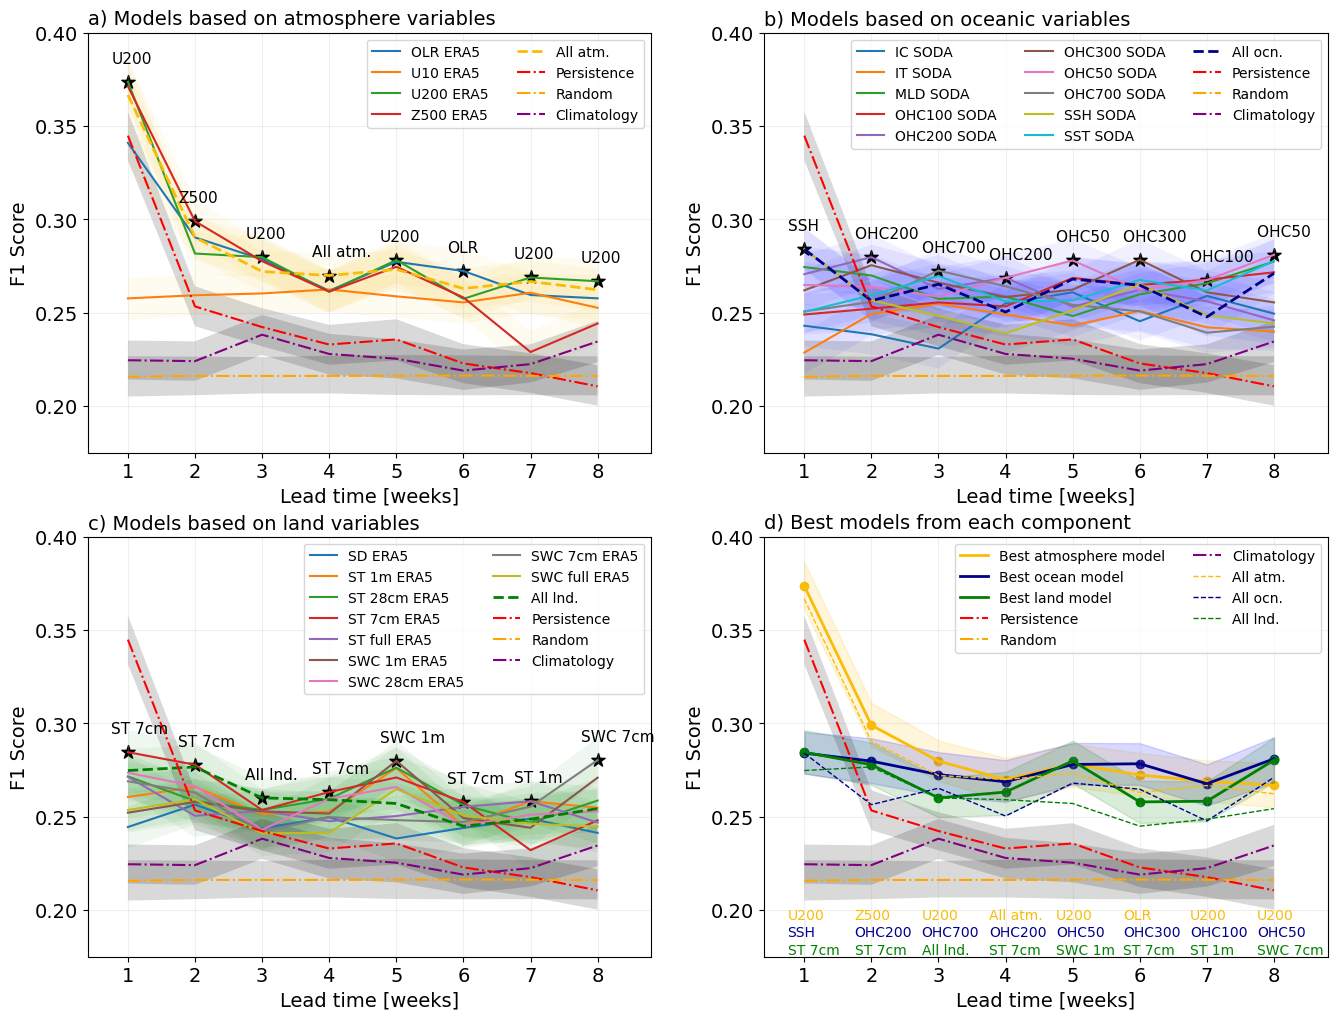

In [50]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2,figsize=(16,12))  # 2x2 grid of subplots
upper_ylim = 0.4
lower_ylim = 0.175
alpha = 0.15
alpha_benchmarks = 0.15
##### ATMOSPHERE ####

for acc_temp, name_temp in zip(dic_atm['all_f1s'][:,:,0], dic_atm['names']):
    if name_temp == 'All atm.':
        axs[0,0].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=1,color='#f9bc08',lw=2,ls='dashed')
    else:
        axs[0,0].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=1)

for acc_temp, name_temp in zip(dic_atm['all_f1s'], dic_atm['names']):
    axs[0,0].fill_between(weeks, acc_temp[:,1],acc_temp[:,2], 
                          color='#f9bc08', ls='dashdot', lw=0.01,alpha=0.06)

# Plot best model
for i, j, d in zip(weeks, np.max(np.array(dic_atm['all_f1s'][:,:,0]), axis=0), dic_atm['best_model'][:]):
    axs[0,0].scatter(i, j, color='k', marker='*', s=100)
    axs[0,0].text(i - 0.25, j + 0.01, s=d.replace('SWVL','SWC').replace('STL','ST').replace('_ERA5',''),fontsize=11)

# Plot benchmarks
axs[0,0].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
axs[0,0].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)


axs[0,0].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
axs[0,0].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)

axs[0,0].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
axs[0,0].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)

# Finalizing plot
axs[0,0].set_ylim(lower_ylim, upper_ylim)
axs[0,0].set_xlim(0.4, 8.8)
axs[0,0].tick_params(axis='both', which='major', labelsize=14)
axs[0,0].grid(alpha=0.2)
axs[0,0].set_ylabel('F1 Score',fontsize=14)
axs[0,0].set_xlabel('Lead time [weeks]',fontsize=14)
axs[0,0].set_title(f'a) Models based on atmosphere variables', loc='left',fontsize=14)
axs[0,0].legend(bbox_to_anchor=(1, 1.0), fontsize=10, ncol=2)


##### OCEAN ####

for acc_temp, name_temp in zip(dic_ocn['all_f1s'][:,:,0], dic_ocn['names']):
    if name_temp == 'All ocn.':
        axs[0,1].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=1,color='darkblue',lw=2,ls='dashed')
    else:
        axs[0,1].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=1)

for acc_temp, name_temp in zip(dic_ocn['all_f1s'], dic_ocn['names']):
    axs[0,1].fill_between(weeks, acc_temp[:,1],acc_temp[:,2], 
                          color='blue', ls='dashdot', lw=0.01,alpha=0.06)
# axs[0,1].fill_between(weeks, dic_ocn['all_f1s'][-1,:,1],dic_ocn['all_f1s'][-1,:,2], 
#                       color='darkblue', ls='dashdot', lw=0.01,alpha=alpha)
# axs[0,1].fill_between(weeks, dic_ocn['all_f1s'][-1,:,1],dic_ocn['all_f1s'][-1,:,2], 
#                       color='darkblue', ls='dashdot', lw=0.01,alpha=alpha)
# Plot best model
for i, j, d in zip(weeks, np.max(np.array(dic_ocn['all_f1s'][:,:,0]), axis=0), dic_ocn['best_model'][:]):
    axs[0,1].scatter(i, j, color='k', marker='*', s=100)
    axs[0,1].text(i - 0.25, j + 0.01, s=d.replace('SWVL','SWC').replace('STL','ST')\
                  .replace('SODA','').replace('_',' ').replace(' OISS','\nOISS').replace(' wT','\nwT'),
                  fontsize=11)

# Plot benchmarks
axs[0,1].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
axs[0,1].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)


axs[0,1].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
axs[0,1].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)

axs[0,1].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
axs[0,1].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)

# Finalizing plot
axs[0,1].set_ylim(lower_ylim, upper_ylim)
axs[0,1].set_xlim(0.4, 8.8)
axs[0,1].tick_params(axis='both', which='major', labelsize=14)
axs[0,1].grid(alpha=0.2)
axs[0,1].set_ylabel('F1 Score',fontsize=14)
axs[0,1].set_xlabel('Lead time [weeks]',fontsize=14)
axs[0,1].set_title(f'b) Models based on oceanic variables', loc='left',fontsize=14)
axs[0,1].legend(bbox_to_anchor=(1, 1.0), fontsize=10, ncol=3)

##### LAND ####

for acc_temp, name_temp in zip(dic_lnd['all_f1s'][:,:,0], dic_lnd['names']):
    if name_temp == 'All lnd.':
        axs[1,0].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=1,color='green',lw=2,ls='dashed')
    else:
        axs[1,0].plot(weeks, np.array(acc_temp)[:], 
                label=(name_temp.replace('_',' ').replace('SWVL','SWC').replace('STL','ST')), 
                alpha=1)
for acc_temp, name_temp in zip(dic_lnd['all_f1s'], dic_lnd['names']):
    axs[1,0].fill_between(weeks, acc_temp[:,1],acc_temp[:,2], 
                          color='green', ls='dashdot', lw=0.01,alpha=0.06)
    
# Plot best model
for i, j, d in zip(weeks, np.max(np.array(dic_lnd['all_f1s'][:,:,0]), axis=0), dic_lnd['best_model'][:]):
    axs[1,0].scatter(i, j, color='k', marker='*', s=100)
    axs[1,0].text(i - 0.25, j + 0.01, s=d.replace('SWVL','SWC').replace('STL','ST')\
                  .replace('ERA5','').replace('_',' ').replace(' wT','\nwT'),fontsize=11)

# Plot benchmarks
axs[1,0].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
axs[1,0].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)


axs[1,0].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
axs[1,0].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)

axs[1,0].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
axs[1,0].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)

# Finalizing plot
axs[1,0].set_ylim(lower_ylim, upper_ylim)
axs[1,0].set_xlim(0.4, 8.8)
axs[1,0].tick_params(axis='both', which='major', labelsize=14)
axs[1,0].grid(alpha=0.2)
axs[1,0].set_ylabel('F1 Score',fontsize=14)
axs[1,0].set_xlabel('Lead time [weeks]',fontsize=14)
axs[1,0].set_title(f'c) Models based on land variables', loc='left',fontsize=14)
axs[1,0].legend(bbox_to_anchor=(1, 1.0), fontsize=10, ncol=2)


#### BEST MODEL ALL COMPONENTS #####

best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                    for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])

best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                    for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])

best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                    for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])

axs[1,1].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
axs[1,1].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)

axs[1,1].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
axs[1,1].scatter(weeks,best_f1_ocn[:,0],color='darkblue')

axs[1,1].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
axs[1,1].scatter(weeks,best_f1_lnd[:,0],color='green')

axs[1,1].fill_between(weeks, best_f1_atm[:,1], 
                 best_f1_atm[:,2], color='#f9bc08', alpha=alpha)
axs[1,1].fill_between(weeks, best_f1_ocn[:,1], 
                 best_f1_ocn[:,2], color='blue', alpha=alpha)
axs[1,1].fill_between(weeks, best_f1_lnd[:,1], 
                 best_f1_lnd[:,2], color='green', alpha=alpha)

# Plot benchmarks
axs[1,1].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
axs[1,1].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)


axs[1,1].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
axs[1,1].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)

axs[1,1].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
axs[1,1].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                      color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)

# Plot best model
for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
    axs[1,1].text(i - 0.25, 0.195-0.0, s=d.replace('_ERA5',''), 
                  color = '#f9bc08',fontsize=10)
for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
    axs[1,1].text(i - 0.25, 0.186-0.0, s=d.replace('_SODA','').replace('_OISSTv2','')\
                  .replace('_wT',' \nwT'), 
                  color = 'darkblue',fontsize=10)
for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
    axs[1,1].text(i - 0.25,  0.176-0.0, s=d.replace('SWVL','SWC').replace('STL','ST')\
                  .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
                  color = 'green',fontsize=10)

# axs[1,1].plot(weeks, f1_all_all[:,0], color='k', label='All vars.', ls='dashed', lw=2)
axs[1,1].plot(weeks, dic_atm['all_f1s'][-1,:,0], color='#f9bc08', label='All atm.', ls='dashed', lw=1)
axs[1,1].plot(weeks, dic_ocn['all_f1s'][-1,:,0], color='darkblue', label='All ocn.', ls='dashed', lw=1)
axs[1,1].plot(weeks, dic_lnd['all_f1s'][-1,:,0], color='green', label='All lnd.', ls='dashed', lw=1)
# axs[1,1].fill_between(weeks, f1_all_all[:,1],f1_all_all[:,2], 
#                       color='blue', ls='dashdot', lw=0.01,alpha=0.05)

axs[1,1].set_xlim(0.4, 8.8)
axs[1,1].set_ylim(lower_ylim, upper_ylim)
axs[1,1].tick_params(axis='both', which='major', labelsize=14)
axs[1,1].grid(alpha=0.2)
axs[1,1].set_ylabel('F1 Score',fontsize=14)
axs[1,1].set_xlabel('Lead time [weeks]',fontsize=14)
axs[1,1].set_title(f'd) Best models from each component', loc='left',fontsize=14)
axs[1,1].legend(bbox_to_anchor=(1, 1.0), fontsize=10,ncol=2)
plt.savefig('2_f1Components.pdf',bbox_inches='tight')

In [51]:
names_vars_ordered = np.array(list_vars)[all_indices]
names_vars_figures = np.array([names_vars_ordered[i].replace('_ERA5','').replace('_SODA','')\
                               .replace('SWVL','SWC').replace('STL','ST')\
                                for i in range(len(names_vars_ordered))])
binary_good = np.zeros([len(all_indices),len(weeks)])
binary_best = np.zeros([len(all_indices),len(weeks)])

for comp,dic_comp in zip(['Atmosphere','Ocean','Land'],[dic_atm,dic_ocn,dic_lnd]):
    print(f'*******************{comp}***********')
    list_comp = []
    for week in weeks:
        # print('Week: ', week)
        where_best_model = np.where(dic_comp['names'] == dic_comp['best_model'][week-1])[0][0]
        best_benchmark_upper = np.max([f1_persistence[week-1,1],f1_random[week-1,1],f1_climatology[week-1,1]])
        # print('best: ',dic_comp['best_model'][week-1])
        where_higher = np.where((dic_comp['all_f1s'][:,week-1,0]>dic_comp['all_f1s'][where_best_model,week-1,2])&
                               (dic_comp['all_f1s'][:,week-1,0]>best_benchmark_upper))[0] # Mean higher than 95th percentile and lower boundary higher than upper benchmark boundary
        where_good = np.where((dic_comp['all_f1s'][:,week-1,0]>best_benchmark_upper))[0] # lower boundary higher than upper benchmark boundary
        where_bad = np.where((dic_comp['all_f1s'][:,week-1,0]<best_benchmark_upper))[0] # lower boundary higher than upper benchmark boundary
        # print('Significantly bad', (', '.join(list(dic_comp['names'][where_bad]))).replace('_ERA5','').replace('_SODA',''))
        good_list = list(dic_comp['names'][where_good])
        best_list = list(dic_comp['names'][where_higher])
        # print('Significantly good and best:', (', '.join(best_list)).replace('_ERA5','').replace('_SODA',''))
        print(week,(', '.join(best_list)).replace('_ERA5','').replace('_SODA',''))
        
        for namegood in good_list:
            whereinfulllist = np.where(names_vars_ordered==namegood)[0]
            binary_good[whereinfulllist,week-1] = 1
        for namebest in best_list:
            whereinfulllist = np.where(names_vars_ordered==namebest)[0]
            binary_best[whereinfulllist,week-1] = 1

*******************Atmosphere***********
1 U200, Z500, All atm.
2 OLR, Z500, All atm.
3 OLR, U200, Z500, All atm.
4 OLR, U10, U200, Z500, All atm.
5 OLR, U200, Z500, All atm.
6 OLR, All atm.
7 OLR, U10, U200, All atm.
8 OLR, U200, All atm.
*******************Ocean***********
1 
2 MLD, OHC200, OHC300
3 OHC200, OHC300, OHC700, SST, All ocn.
4 MLD, OHC200, OHC300, OHC50, OHC700
5 OHC100, OHC50, All ocn.
6 OHC300, SST
7 IC, MLD, OHC100, OHC200, OHC300, OHC50, SST
8 MLD, OHC100, OHC50, SST, All ocn.
*******************Land***********
1 
2 STL_7cm, All lnd.
3 STL_28cm, STL_7cm, STL_full, SWVL_1m, All lnd.
4 STL_1m, STL_28cm, STL_7cm, SWVL_1m, SWVL_28cm, All lnd.
5 STL_1m, STL_28cm, STL_7cm, SWVL_1m
6 STL_28cm, STL_7cm, STL_full, SWVL_1m, SWVL_7cm, SWVL_full
7 SD, STL_1m, STL_full, SWVL_28cm, SWVL_7cm, All lnd.
8 SWVL_1m, SWVL_7cm


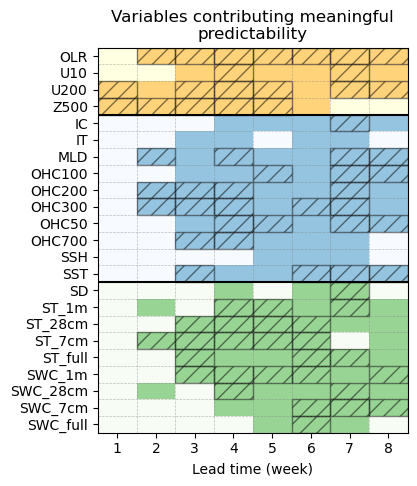

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure and axis
fig, ax = plt.subplots(figsize=(4, 5))

# Plot the main data
cmesh = ax.pcolormesh(weeks, np.arange(len(names_vars_figures))[:4], binary_good[:4], cmap='afmhot_r', vmin=-0.3, vmax=3.2,alpha=0.7)
cmesh = ax.pcolormesh(weeks, np.arange(len(names_vars_figures))[4:14], binary_good[4:14], cmap='Blues', vmin=0, vmax=2.5)
cmesh = ax.pcolormesh(weeks, np.arange(len(names_vars_figures))[14:], binary_good[14:], cmap='Greens', vmin=0, vmax=2.5)

# Overlay hatching where binary_best == 1
for i in range(binary_best.shape[0]):
    for j in range(binary_best.shape[1]):
        if binary_best[i, j] == 1:
            rect = plt.Rectangle((weeks[j] - 0.5, i - 0.5), 1, 1, facecolor='none', 
                                  edgecolor='black', hatch='//', alpha=0.5)
            ax.add_patch(rect)

for xpos in np.arange(0.5,9,1):
    ax.axvline(xpos, color='gray', ls='dashed', alpha=0.5, lw=0.5)

for ypos in np.arange(0.5,23,1):
    ax.axhline(ypos, color='gray', ls='dashed', alpha=0.5, lw=0.5)

ax.axhline(3.5, color='k')
ax.axhline(13.5, color='k')

# Adjust axes
ax.set_yticks(np.arange(len(names_vars_figures)))
ax.set_yticklabels(names_vars_figures)
ax.set_xticks(weeks)
ax.set_xlabel('Lead time (week)')

ax.set_title('Variables contributing meaningful\npredictability')

# Invert the y-axis
ax.invert_yaxis()

plt.savefig('3_VarsContribution.pdf',bbox_inches='tight')

# Seasonal plots

In [54]:
indices_seasons = {'Winter':[12,1,2],
                   'Spring':[3,4,5],
                   'Summer':[6,7,8],
                   'Fall':[9,10,11]}

In [55]:
path_f1s_seasonal = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_seasonal/'

SEASON-------------------------------------> Winter
*******************Atmosphere***********
1 U200, Z500, All atm.
2 Z500, All atm.
3 U200
4 U10, Z500, All atm.
5 OLR, U200, All atm.
6 OLR, U10, Z500, All atm.
7 OLR, U10, U200, All atm.
8 OLR
*******************Ocean***********
1 
2 
3 OHC300
4 MLD, OHC100, OHC200, OHC300, OHC50
5 OHC50, SST
6 OHC100
7 OHC100, OHC200, OHC50, SSH, SST
8 IC, MLD, OHC100, OHC50, SST
*******************Land***********
1 
2 
3 
4 
5 
6 STL_full
7 
8 SWVL_7cm
SEASON-------------------------------------> Spring
*******************Atmosphere***********
1 U200
2 
3 
4 
5 
6 
7 
8 U10
*******************Ocean***********
1 
2 SSH
3 IT, SSH
4 
5 OHC300
6 IT, OHC300
7 MLD
8 MLD, OHC100, OHC50, SST, All ocn.
*******************Land***********
1 
2 
3 
4 
5 STL_1m
6 
7 STL_full
8 STL_1m, STL_28cm, STL_7cm, SWVL_1m, SWVL_full
SEASON-------------------------------------> Summer
*******************Atmosphere***********
1 
2 OLR, Z500, All atm.
3 OLR, U200, Z500
4 OLR, 

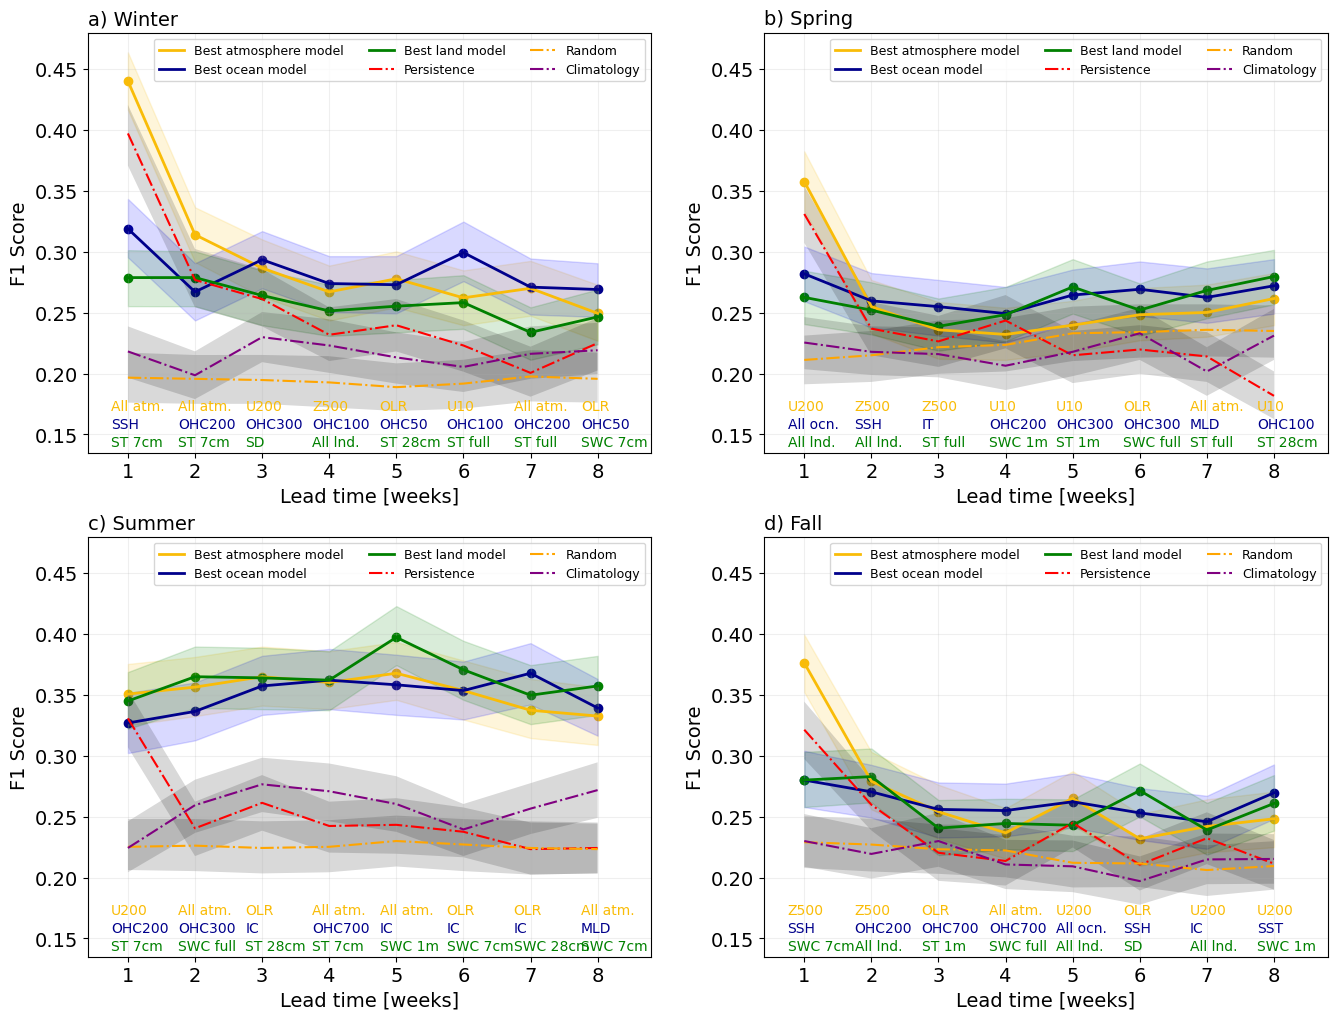

In [56]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2,figsize=(16,12))  # 2x2 grid of subplots

# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

dic_good = {}
dic_best = {}

for iseason, season in enumerate(indices_seasons.keys()):
    print('SEASON------------------------------------->',season)
    dic_atm = {}
    dic_atm['all_f1s'] = []
    dic_atm['names'] = []
    
    for ivar in indices_vars_atm:
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_{list_vars[ivar]}_{season}.npy'))
        dic_atm['names'].append(list_vars[ivar])
    dic_atm['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_atm_{season}.npy'))
    dic_atm['names'].append(f'All atm.')
    
    dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
    dic_atm['names'] = np.array(dic_atm['names'])
    dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_ocn = {}
    dic_ocn['all_f1s'] = []
    dic_ocn['names'] = []
    
    for ivar in indices_vars_ocn:
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_{list_vars[ivar]}_{season}.npy'))
        dic_ocn['names'].append(list_vars[ivar])
    dic_ocn['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_ocn_{season}.npy'))
    dic_ocn['names'].append(f'All ocn.')
    
    dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
    dic_ocn['names'] = np.array(dic_ocn['names'])
    dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_lnd = {}
    dic_lnd['all_f1s'] = []
    dic_lnd['names'] = []
    
    for ivar in indices_vars_lnd:
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_{list_vars[ivar]}_{season}.npy'))
        dic_lnd['names'].append(list_vars[ivar])
    dic_lnd['all_f1s'].append(np.load(f'{path_f1s_seasonal}/f1_lnd_{season}.npy'))
    dic_lnd['names'].append(f'All lnd.')
    
    dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
    dic_lnd['names'] = np.array(dic_lnd['names'])
    dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
    
    f1_persistence = np.load(f'{path_f1s_seasonal}/f1_persistence_{season}.npy')
    f1_climatology = np.load(f'{path_f1s_seasonal}/f1_climatology_{season}.npy')
    f1_random = np.load(f'{path_f1s_seasonal}/f1_random_{season}.npy')
    f1_all = np.load(f'{path_f1s_seasonal}/f1_all_{season}.npy')

    binary_good = np.zeros([len(all_indices),len(weeks)])
    binary_best = np.zeros([len(all_indices),len(weeks)])
    
    for comp,dic_comp in zip(['Atmosphere','Ocean','Land'],[dic_atm,dic_ocn,dic_lnd]):
        print(f'*******************{comp}***********')
        list_comp = []
        for week in weeks:
            # print('Week: ', week)
            where_best_model = np.where(dic_comp['names'] == dic_comp['best_model'][week-1])[0][0]
            best_benchmark_upper = np.max([f1_persistence[week-1,1],f1_random[week-1,1],f1_climatology[week-1,1]])
            # print('best: ',dic_comp['best_model'][week-1])
            where_higher = np.where((dic_comp['all_f1s'][:,week-1,0]>dic_comp['all_f1s'][where_best_model,week-1,2])&
                                   (dic_comp['all_f1s'][:,week-1,0]>best_benchmark_upper))[0] # Mean higher than 95th percentile and lower boundary higher than upper benchmark boundary
            where_good = np.where((dic_comp['all_f1s'][:,week-1,0]>best_benchmark_upper))[0] # lower boundary higher than upper benchmark boundary
            where_bad = np.where((dic_comp['all_f1s'][:,week-1,0]<best_benchmark_upper))[0] # lower boundary higher than upper benchmark boundary
            # print('Significantly bad', (', '.join(list(dic_comp['names'][where_bad]))).replace('_ERA5','').replace('_SODA',''))
            good_list = list(dic_comp['names'][where_good])
            best_list = list(dic_comp['names'][where_higher])
            # print('Significantly good and best:', (', '.join(best_list)).replace('_ERA5','').replace('_SODA',''))
            print(week,(', '.join(best_list)).replace('_ERA5','').replace('_SODA',''))
            
            for namegood in good_list:
                whereinfulllist = np.where(names_vars_ordered==namegood)[0]
                binary_good[whereinfulllist,week-1] = 1
            for namebest in best_list:
                whereinfulllist = np.where(names_vars_ordered==namebest)[0]
                binary_best[whereinfulllist,week-1] = 1
    weeks = np.arange(1,9)
    dic_good[season] = binary_good
    dic_best[season] = binary_best

    ##### PLOT

    best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])
    
    axs_list[iseason].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
    axs_list[iseason].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
    
    axs_list[iseason].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
    axs_list[iseason].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
    
    axs_list[iseason].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
    axs_list[iseason].scatter(weeks,best_f1_lnd[:,0],color='green')
    
    axs_list[iseason].fill_between(weeks, best_f1_atm[:,1], 
                     best_f1_atm[:,2], color='#f9bc08', alpha=alpha)
    axs_list[iseason].fill_between(weeks, best_f1_ocn[:,1], 
                     best_f1_ocn[:,2], color='blue', alpha=alpha)
    axs_list[iseason].fill_between(weeks, best_f1_lnd[:,1], 
                     best_f1_lnd[:,2], color='green', alpha=alpha)
    
    # Plot benchmarks
    axs_list[iseason].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
    axs_list[iseason].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                          color='black', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
    
    
    axs_list[iseason].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
    axs_list[iseason].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                          color='black', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
    
    axs_list[iseason].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
    axs_list[iseason].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                          color='black', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)

    ## Plot joint model
    # axs_list[iseason].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
    # axs_list[iseason].fill_between(weeks, f1_all[:,1],f1_all[:,2], 
    #                       color='k', ls='dashed', lw=0.01,alpha=0.1)
    
    # Plot best model
    for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        axs_list[iseason].text(i - 0.25, 0.22-0.05, s=d.replace('_ERA5',''), 
                      color = '#f9bc08',fontsize=10)
    for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        axs_list[iseason].text(i - 0.25, 0.205-0.05, s=d.replace('_SODA','').replace('_OISSTv2','')\
                      .replace('_wT',' \nwT'), 
                      color = 'darkblue',fontsize=10)
    for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        axs_list[iseason].text(i - 0.25,  0.19-0.05, s=d.replace('SWVL','SWC').replace('STL','ST')\
                      .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
                      color = 'green',fontsize=10)
    
    axs_list[iseason].set_xlim(0.4, 8.8)
    axs_list[iseason].set_ylim(0.135, 0.48)
    axs_list[iseason].tick_params(axis='both', which='major', labelsize=14)
    axs_list[iseason].grid(alpha=0.2)
    axs_list[iseason].set_ylabel('F1 Score',fontsize=14)
    axs_list[iseason].set_xlabel('Lead time [weeks]',fontsize=14)
    abcd = list(string.ascii_lowercase)
    axs_list[iseason].set_title(f'{abcd[iseason]}) {list(indices_seasons.keys())[iseason]}', loc='left',fontsize=14)
    axs_list[iseason].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=3)
plt.savefig('4_f1Seasonal.png',bbox_inches='tight')

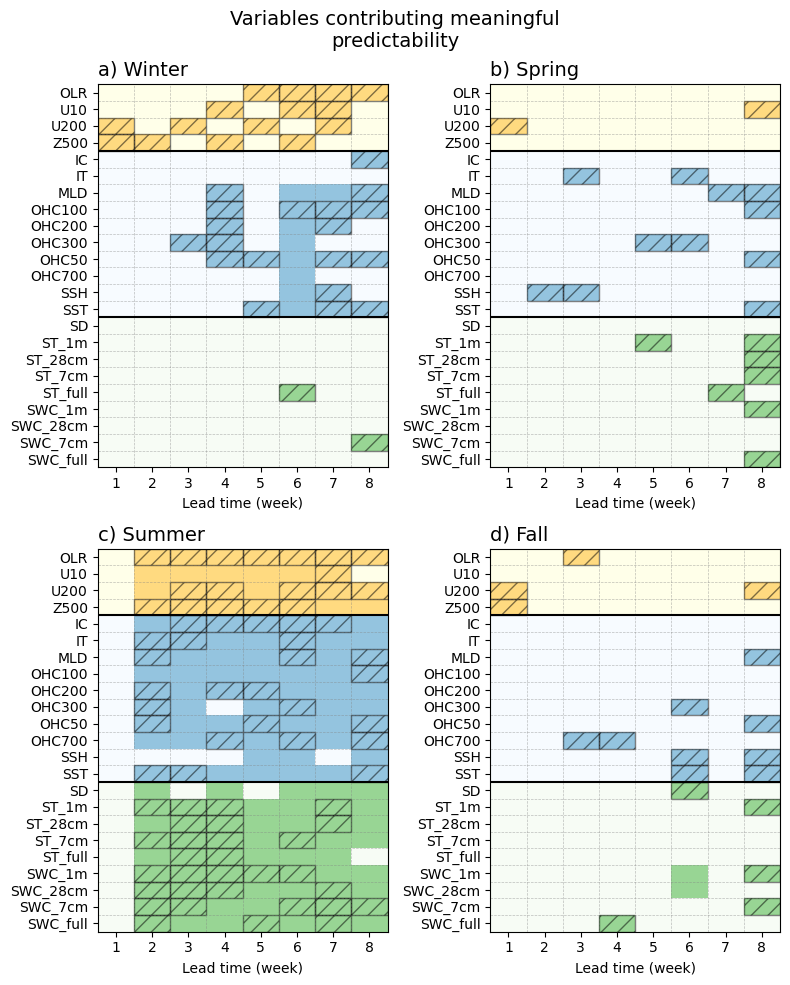

In [57]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2,figsize=(8,10))  # 2x2 grid of subplots

# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

for iseason, season in enumerate(indices_seasons.keys()):
    # Plot the main data
    cmesh = axs_list[iseason].pcolormesh(weeks, 
                                         np.arange(len(names_vars_figures))[:4], 
                                         dic_good[season][:4], cmap='afmhot_r', vmin=-0.2, vmax=3.2,alpha=0.7)
    cmesh = axs_list[iseason].pcolormesh(weeks, 
                                         np.arange(len(names_vars_figures))[4:14], 
                                         dic_good[season][4:14], cmap='Blues', vmin=0, vmax=2.5)
    cmesh = axs_list[iseason].pcolormesh(weeks, 
                                         np.arange(len(names_vars_figures))[14:], 
                                         dic_good[season][14:], cmap='Greens', vmin=0., vmax=2.5)

    # Overlay hatching where binary_best == 1
    for i in range(dic_best[season].shape[0]):
        for j in range(dic_best[season].shape[1]):
            if dic_best[season][i, j] == 1:
                rect = plt.Rectangle((weeks[j] - 0.5, i - 0.5), 1, 1, facecolor='none', 
                                      edgecolor='black', hatch='//', alpha=0.5)
                axs_list[iseason].add_patch(rect)
    
    for xpos in np.arange(0.5,9,1):
        axs_list[iseason].axvline(xpos, color='gray', ls='dashed', alpha=0.5, lw=0.5)
    
    for ypos in np.arange(0.5,23,1):
        axs_list[iseason].axhline(ypos, color='gray', ls='dashed', alpha=0.5, lw=0.5)
    
    axs_list[iseason].axhline(3.5, color='k')
    axs_list[iseason].axhline(13.5, color='k')
    
    # Adjust axes
    axs_list[iseason].set_yticks(np.arange(len(names_vars_figures)))
    axs_list[iseason].set_yticklabels(names_vars_figures)
    axs_list[iseason].set_xticks(weeks)
    axs_list[iseason].set_xlabel('Lead time (week)')
    
    axs_list[iseason].set_title(f'{abcd[iseason]}) {list(indices_seasons.keys())[iseason]}', loc='left',fontsize=14)
    
    # Invert the y-axis
    axs_list[iseason].invert_yaxis()

fig.suptitle('Variables contributing meaningful\npredictability',fontsize=14)
plt.tight_layout()
plt.savefig('A1_VarsContribution_seasonal.pdf',bbox_inches='tight')

# WR-Dependent performance which WR is easier/harder to predict per season

In [58]:
names_wr = ["WR1: PT", "WR2: PR", "WR3: GH", "WR4: AR", "No WR"]

In [59]:
path_f1s_wrs = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_wrs/'

----------------------------------------->WR:  WR1: PT
*******************Atmosphere***********
1 U200, Z500, All atm.
2 U200, Z500, All atm.
3 U200
4 U200, Z500, All atm.
5 U10, U200, Z500
6 OLR, U200, All atm.
7 U200
8 U200, Z500, All atm.
*******************Ocean***********
1 
2 OHC300
3 OHC300, OHC700, All ocn.
4 IT, OHC300, OHC50, OHC700, All ocn.
5 OHC50
6 OHC100, OHC200, OHC300, SSH, SST
7 MLD, OHC100, SSH, SST
8 SST
*******************Land***********
1 
2 SD
3 SD
4 STL_7cm
5 
6 
7 SD
8 STL_1m
----------------------------------------->WR:  WR2: PR
*******************Atmosphere***********
1 
2 
3 U10, Z500, All atm.
4 U10, All atm.
5 
6 
7 U10, All atm.
8 U10
*******************Ocean***********
1 
2 
3 SSH
4 OHC50
5 OHC100, OHC50, SST, All ocn.
6 OHC50
7 OHC50
8 OHC50, SST
*******************Land***********
1 
2 
3 SD
4 SD
5 SD
6 STL_full
7 SD
8 SWVL_1m, SWVL_7cm
----------------------------------------->WR:  WR3: GH
*******************Atmosphere***********
1 U200, Z500, All atm.

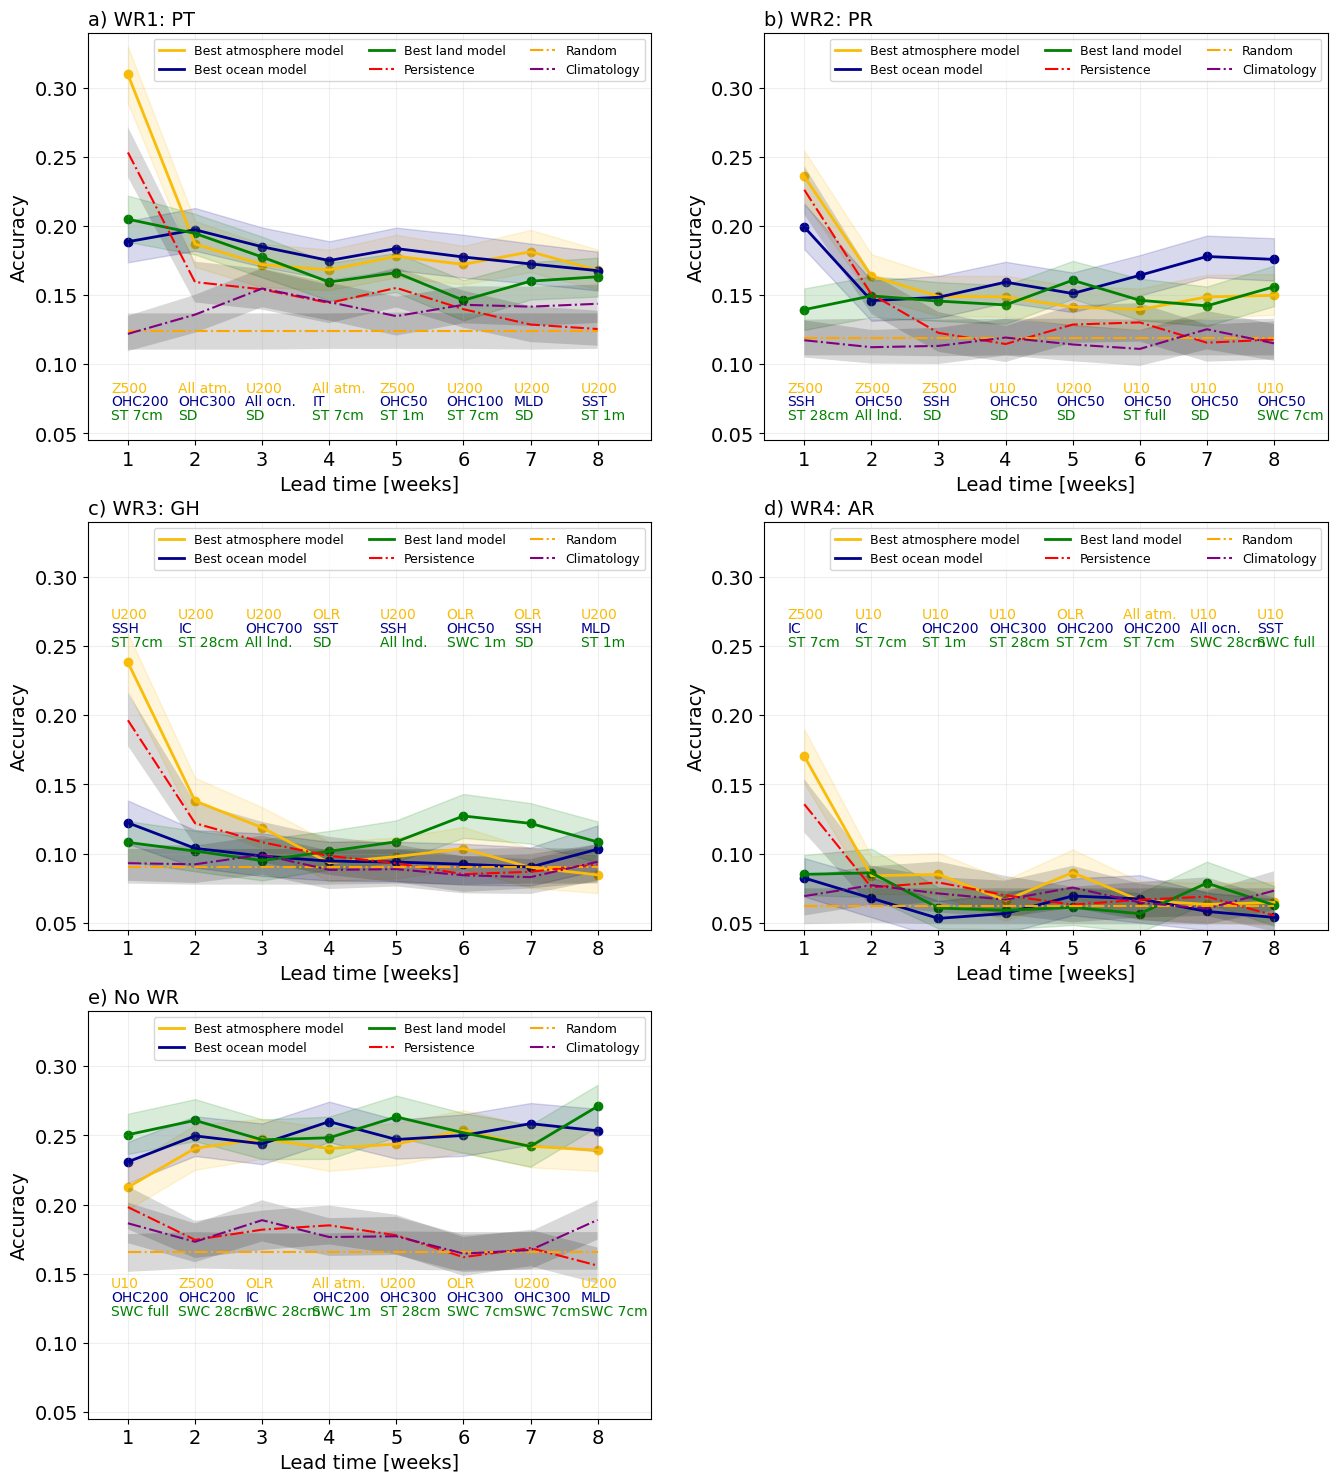

In [60]:
lower_ylim = 0.08
upper_ylim = 0.4

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2,figsize=(16,18))  # 2x2 grid of subplots

# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

dic_good = {}
dic_best = {}

for weather_regime, weather_regime_name in enumerate(names_wr):
    print('----------------------------------------->WR: ',weather_regime_name)
    dic_atm = {}
    dic_atm['all_f1s'] = []
    dic_atm['names'] = []
    
    for ivar in indices_vars_atm:
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_atm['names'].append(list_vars[ivar])
    dic_atm['all_f1s'].append(np.load(f'{path_f1s_wrs}/f1_atm_wr{weather_regime}.npy'))
    dic_atm['names'].append(f'All atm.')
    
    dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
    dic_atm['names'] = np.array(dic_atm['names'])
    dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_ocn = {}
    dic_ocn['all_f1s'] = []
    dic_ocn['names'] = []
    
    for ivar in indices_vars_ocn:
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_ocn['names'].append(list_vars[ivar])
    dic_ocn['all_f1s'].append(np.load(f'{path_f1s_wrs}/f1_ocn_wr{weather_regime}.npy'))
    dic_ocn['names'].append(f'All ocn.')
    
    dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
    dic_ocn['names'] = np.array(dic_ocn['names'])
    dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_lnd = {}
    dic_lnd['all_f1s'] = []
    dic_lnd['names'] = []
    
    for ivar in indices_vars_lnd:
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_lnd['names'].append(list_vars[ivar])
    dic_lnd['all_f1s'].append(np.load(f'{path_f1s_wrs}/f1_lnd_wr{weather_regime}.npy'))
    dic_lnd['names'].append(f'All lnd.')
    
    dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
    dic_lnd['names'] = np.array(dic_lnd['names'])
    dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
    
    f1_persistence = np.load(f'{path_f1s_wrs}f1_persistence_wr{weather_regime}.npy')
    f1_climatology = np.load(f'{path_f1s_wrs}f1_climatology_wr{weather_regime}.npy')
    f1_random = np.load(f'{path_f1s_wrs}f1_random_wr{weather_regime}.npy')
    f1_all = np.load(f'{path_f1s_wrs}/f1_all_wr{weather_regime}.npy')
    weeks = np.arange(1,9)
    
    binary_good = np.zeros([len(all_indices),len(weeks)])
    binary_best = np.zeros([len(all_indices),len(weeks)])
    
    for comp,dic_comp in zip(['Atmosphere','Ocean','Land'],[dic_atm,dic_ocn,dic_lnd]):
        print(f'*******************{comp}***********')
        list_comp = []
        for week in weeks:
            # print('Week: ', week)
            where_best_model = np.where(dic_comp['names'] == dic_comp['best_model'][week-1])[0][0]
            best_benchmark_upper = np.max([f1_persistence[week-1,1],f1_random[week-1,1],f1_climatology[week-1,1]])
            # print('best: ',dic_comp['best_model'][week-1])
            where_higher = np.where((dic_comp['all_f1s'][:,week-1,0]>dic_comp['all_f1s'][where_best_model,week-1,2])&
                                   (dic_comp['all_f1s'][:,week-1,0]>best_benchmark_upper))[0] # Mean higher than 95th percentile and lower boundary higher than upper benchmark boundary
            where_good = np.where((dic_comp['all_f1s'][:,week-1,0]>best_benchmark_upper))[0] # lower boundary higher than upper benchmark boundary
            where_bad = np.where((dic_comp['all_f1s'][:,week-1,0]<best_benchmark_upper))[0] # lower boundary higher than upper benchmark boundary
            # print('Significantly bad', (', '.join(list(dic_comp['names'][where_bad]))).replace('_ERA5','').replace('_SODA',''))
            good_list = list(dic_comp['names'][where_good])
            best_list = list(dic_comp['names'][where_higher])
            # print('Significantly good and best:', (', '.join(best_list)).replace('_ERA5','').replace('_SODA',''))
            print(week,(', '.join(best_list)).replace('_ERA5','').replace('_SODA',''))
            
            for namegood in good_list:
                whereinfulllist = np.where(names_vars_ordered==namegood)[0]
                binary_good[whereinfulllist,week-1] = 1
            for namebest in best_list:
                whereinfulllist = np.where(names_vars_ordered==namebest)[0]
                binary_best[whereinfulllist,week-1] = 1
    weeks = np.arange(1,9)
    dic_good[weather_regime] = binary_good
    dic_best[weather_regime] = binary_best

    ##### PLOT

    best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])
    
    axs_list[weather_regime].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
    
    axs_list[weather_regime].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
    
    axs_list[weather_regime].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_lnd[:,0],color='green')
    
    axs_list[weather_regime].fill_between(weeks, best_f1_atm[:,1], 
                     best_f1_atm[:,2], color='#f9bc08', alpha=alpha)
    axs_list[weather_regime].fill_between(weeks, best_f1_ocn[:,1], 
                     best_f1_ocn[:,2], color='darkblue', alpha=alpha)
    axs_list[weather_regime].fill_between(weeks, best_f1_lnd[:,1], 
                     best_f1_lnd[:,2], color='green', alpha=alpha)
    
    # Plot benchmarks
    axs_list[weather_regime].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                          color='black', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
    
    
    axs_list[weather_regime].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                          color='black', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
    
    axs_list[weather_regime].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                          color='black', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
    # ## Plot joint model
    # axs_list[weather_regime].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
    
    constant = -0.12
    if weather_regime==2:
        constant = 0.07
    if weather_regime==3:
        constant = 0.07
    if weather_regime==4:
        constant = -0.06
    # Plot best model
    for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25, 0.20+constant, s=d.replace('_ERA5',''), 
                      color = '#f9bc08',fontsize=10)
    for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25, 0.19+constant, s=d.replace('_SODA','').replace('_OISSTv2','')\
                      .replace('_wT',' \nwT'), 
                      color = 'darkblue',fontsize=10)
    for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25,  0.18+constant, s=d.replace('SWVL','SWC').replace('STL','ST')\
                      .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
                      color = 'green',fontsize=10)
    
    axs_list[weather_regime].set_xlim(0.4, 8.8)
    axs_list[weather_regime].set_ylim(0.045, 0.34)
    axs_list[weather_regime].tick_params(axis='both', which='major', labelsize=14)
    axs_list[weather_regime].grid(alpha=0.2)
    axs_list[weather_regime].set_ylabel('Accuracy',fontsize=14)
    axs_list[weather_regime].set_xlabel('Lead time [weeks]',fontsize=14)
    abcd = list(string.ascii_lowercase)
    axs_list[weather_regime].set_title(f'{abcd[weather_regime]}) {weather_regime_name}', loc='left',fontsize=14)
    axs_list[weather_regime].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=3)

axs_list[-1].remove()
plt.savefig('5_accWRs.pdf',bbox_inches='tight')

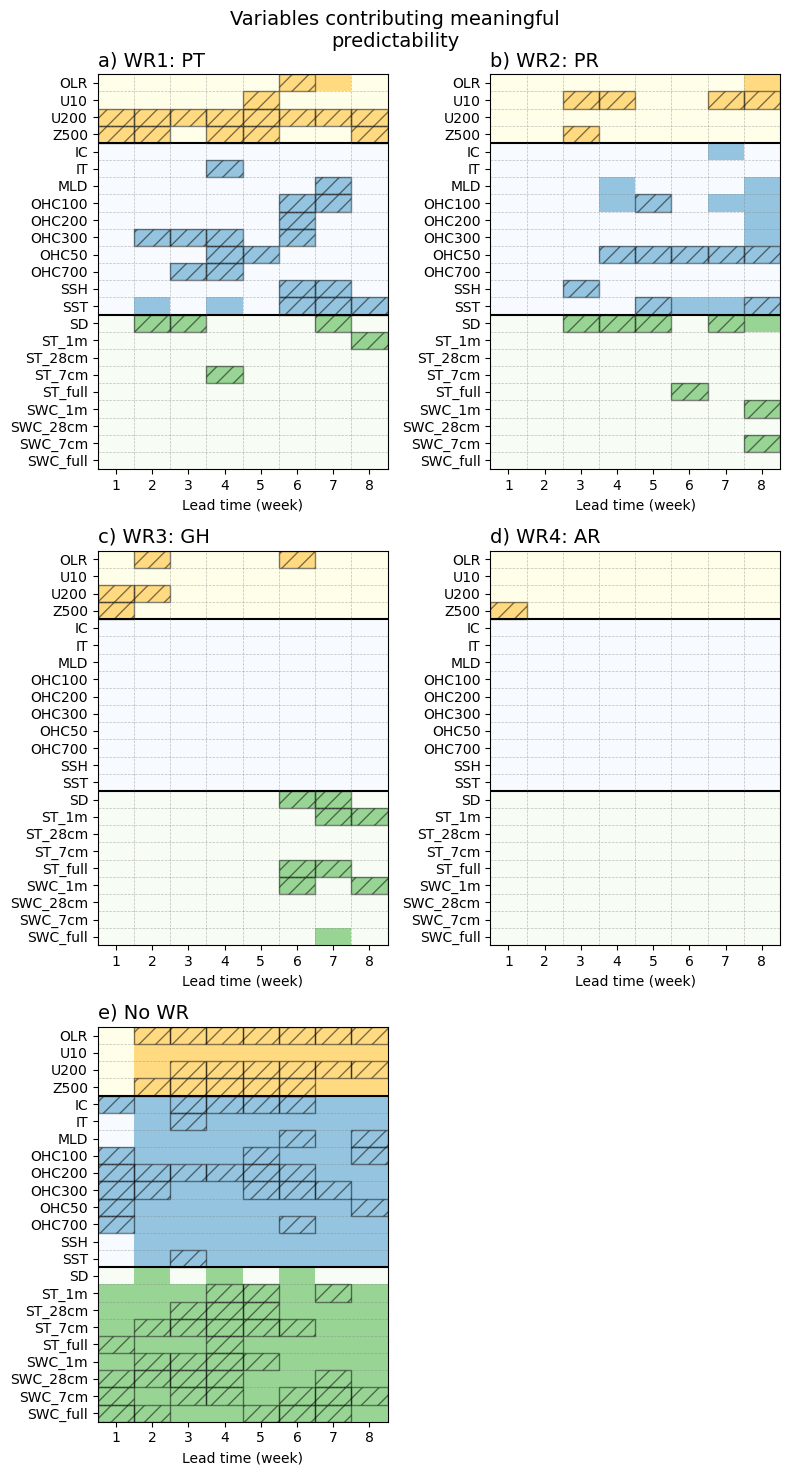

In [63]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2,figsize=(8,15))  # 2x2 grid of subplots

# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

for weather_regime, weather_regime_name in enumerate(names_wr):
    # Plot the main data
    cmesh = axs_list[weather_regime].pcolormesh(weeks, 
                                         np.arange(len(names_vars_figures))[:4], 
                                         dic_good[weather_regime][:4], cmap='afmhot_r', vmin=-0.2, vmax=3.2,alpha=0.7)
    cmesh = axs_list[weather_regime].pcolormesh(weeks, 
                                         np.arange(len(names_vars_figures))[4:14], 
                                         dic_good[weather_regime][4:14], cmap='Blues', vmin=0, vmax=2.5)
    cmesh = axs_list[weather_regime].pcolormesh(weeks, 
                                         np.arange(len(names_vars_figures))[14:], 
                                         dic_good[weather_regime][14:], cmap='Greens', vmin=0., vmax=2.5)
    
    # Overlay hatching where binary_best == 1
    for i in range(dic_best[weather_regime].shape[0]):
        for j in range(dic_best[weather_regime].shape[1]):
            if dic_best[weather_regime][i, j] == 1:
                rect = plt.Rectangle((weeks[j] - 0.5, i - 0.5), 1, 1, facecolor='none', 
                                      edgecolor='black', hatch='//', alpha=0.5)
                axs_list[weather_regime].add_patch(rect)
    
    for xpos in np.arange(0.5,9,1):
        axs_list[weather_regime-1].axvline(xpos, color='gray', ls='dashed', alpha=0.5, lw=0.5)
    
    for ypos in np.arange(0.5,23,1):
        axs_list[weather_regime].axhline(ypos, color='gray', ls='dashed', alpha=0.5, lw=0.5)
    
    axs_list[weather_regime].axhline(3.5, color='k')
    axs_list[weather_regime].axhline(13.5, color='k')
    
    # Adjust axes
    axs_list[weather_regime].set_yticks(np.arange(len(names_vars_figures)))
    axs_list[weather_regime].set_yticklabels(names_vars_figures)
    axs_list[weather_regime].set_xticks(weeks)
    axs_list[weather_regime].set_xlabel('Lead time (week)')
    
    axs_list[weather_regime].set_title(f'{abcd[weather_regime]}) {weather_regime_name}', loc='left',fontsize=14)
    
    # Invert the y-axis
    axs_list[weather_regime].invert_yaxis()
axs_list[-1].remove()
fig.suptitle('Variables contributing meaningful\npredictability',fontsize=14)
plt.tight_layout()
plt.savefig('A2_VarsContributionWRs.pdf',bbox_inches='tight')

# WR-dependent performance seasonally

In [64]:
path_f1s_wrs_seasonal = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_wrs_seasonal/'

WR -------------------------------------------------------------------> WR1: PT
Season ------------------------------------------->:  Winter
*******************Atmosphere***********
1 Z500, All atm.
2 U200, All atm.
3 
4 Z500
5 OLR
6 All atm.
7 U200
8 U200, All atm.
*******************Ocean***********
1 
2 OHC200, OHC300
3 OHC200, OHC300
4 OHC200, OHC300
5 OHC50
6 OHC100, OHC200
7 OHC100, OHC200
8 
*******************Land***********
1 
2 
3 
4 
5 
6 
7 
8 
Season ------------------------------------------->:  Spring
*******************Atmosphere***********
1 U200, Z500, All atm.
2 U200, All atm.
3 
4 
5 U10
6 
7 
8 
*******************Ocean***********
1 
2 OHC200, OHC50, SST
3 
4 
5 OHC200
6 OHC300, SST
7 MLD
8 IC
*******************Land***********
1 
2 SD, STL_full, All lnd.
3 SD, STL_full
4 
5 STL_1m
6 
7 STL_1m
8 STL_1m
Season ------------------------------------------->:  Summer
*******************Atmosphere***********
1 
2 
3 
4 
5 
6 
7 
8 
*******************Ocean***********
1 


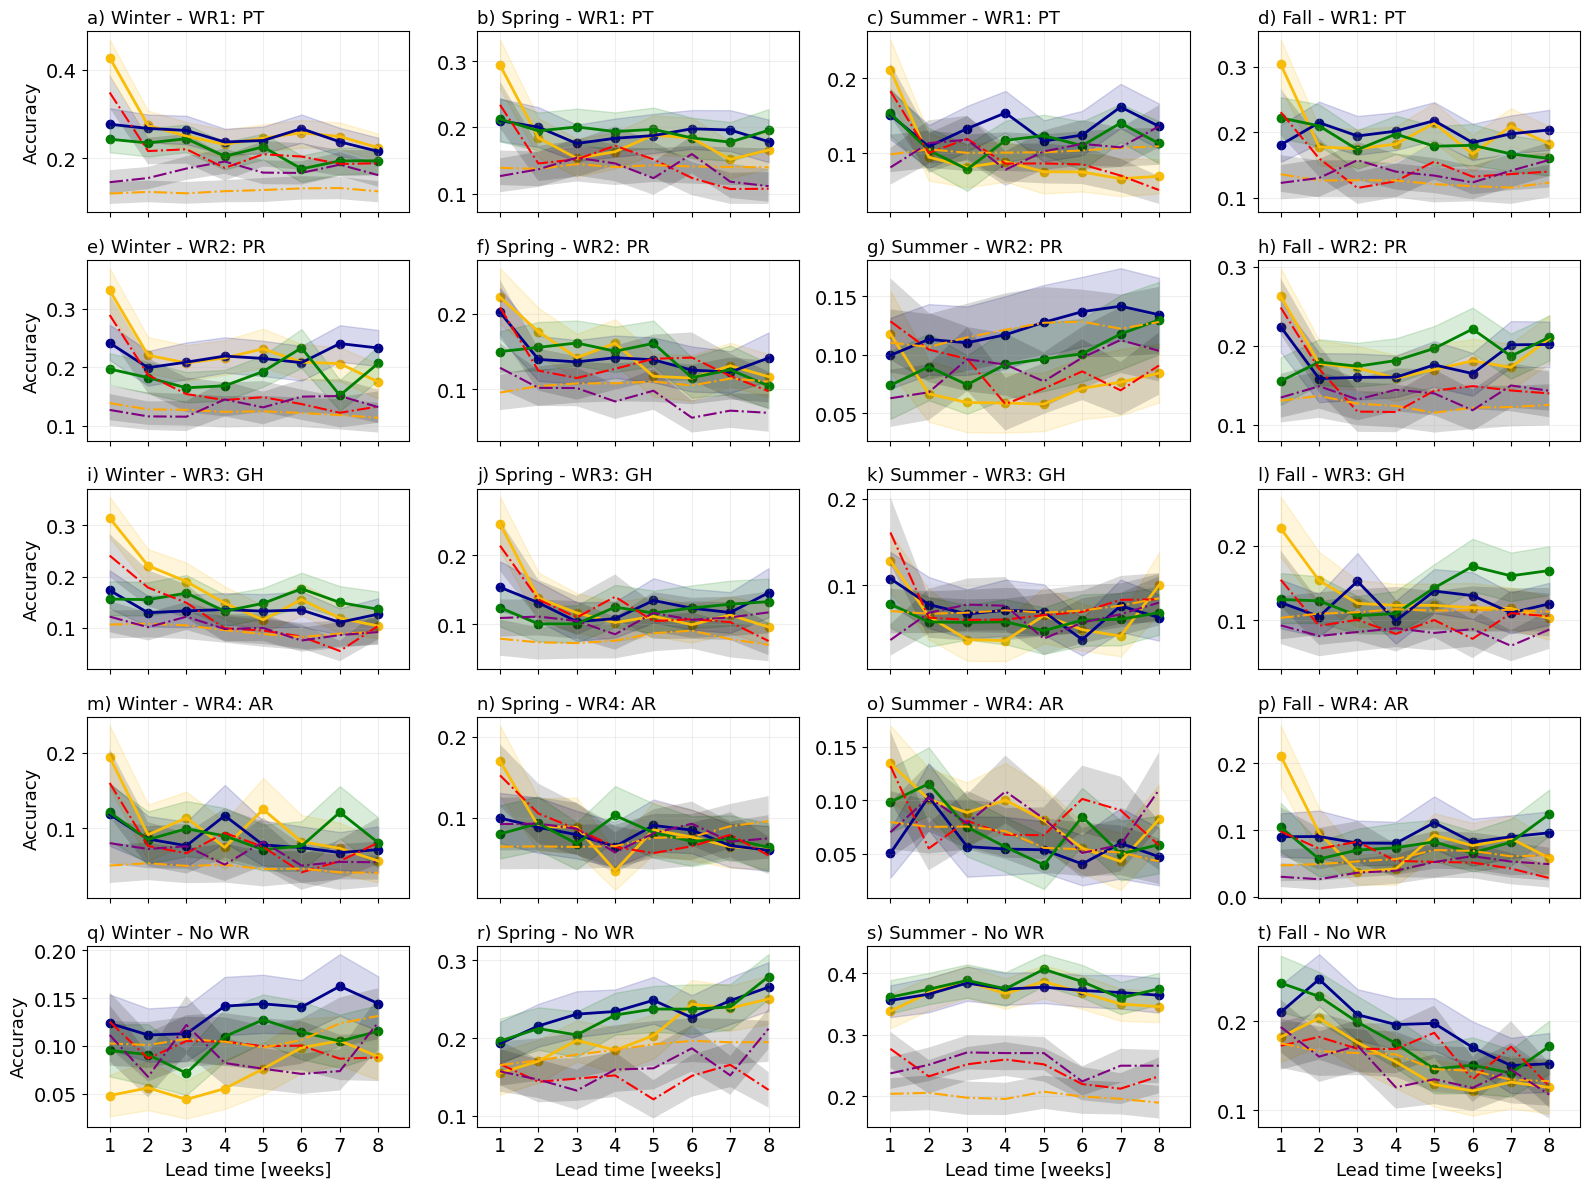

In [65]:
alphabet = list(string.ascii_lowercase)
weeks = np.arange(1, 9)

# Create a figure and a set of subplots
fig, axs = plt.subplots(5, 4, figsize=(16, 12))  # 4x4 grid of subplots
axs_list = axs.flatten().tolist()

counter2 = 0
for weather_regime, weather_regime_name in enumerate(names_wr):
    print('WR ------------------------------------------------------------------->',weather_regime_name)
    wr = weather_regime
    for iseason, season in enumerate(indices_seasons.keys()):
        print('Season ------------------------------------------->: ',season)
        dic_atm = {}
        dic_atm['all_f1s'] = []
        dic_atm['names'] = []
        
        for ivar in indices_vars_atm:
            dic_atm['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_atm['names'].append(list_vars[ivar])
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}/f1_atm_wr{weather_regime}_{season}.npy'))
        dic_atm['names'].append(f'All atm.')
        
        dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
        dic_atm['names'] = np.array(dic_atm['names'])
        dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
        
        dic_ocn = {}
        dic_ocn['all_f1s'] = []
        dic_ocn['names'] = []
        
        for ivar in indices_vars_ocn:
            dic_ocn['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_ocn['names'].append(list_vars[ivar])
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}/f1_ocn_wr{weather_regime}_{season}.npy'))
        dic_ocn['names'].append(f'All ocn.')
        
        dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
        dic_ocn['names'] = np.array(dic_ocn['names'])
        dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
        
        dic_lnd = {}
        dic_lnd['all_f1s'] = []
        dic_lnd['names'] = []
        
        for ivar in indices_vars_lnd:
            dic_lnd['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_lnd['names'].append(list_vars[ivar])
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_wrs_seasonal}/f1_lnd_wr{weather_regime}_{season}.npy'))
        dic_lnd['names'].append(f'All lnd.')
        
        dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
        dic_lnd['names'] = np.array(dic_lnd['names'])
        dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
        
        f1_persistence = np.load(f'{path_f1s_wrs_seasonal}f1_persistence_wr{weather_regime}_{season}.npy')
        f1_climatology = np.load(f'{path_f1s_wrs_seasonal}f1_climatology_wr{weather_regime}_{season}.npy')
        f1_random = np.load(f'{path_f1s_wrs_seasonal}f1_random_wr{weather_regime}_{season}.npy')
        f1_all = np.load(f'{path_f1s_wrs_seasonal}/f1_all_wr{weather_regime}_{season}.npy')
        
        binary_good = np.zeros([len(all_indices),len(weeks)])
        binary_best = np.zeros([len(all_indices),len(weeks)])
        
        for comp,dic_comp in zip(['Atmosphere','Ocean','Land'],[dic_atm,dic_ocn,dic_lnd]):
            print(f'*******************{comp}***********')
            list_comp = []
            for week in weeks:
                # print('Week: ', week)
                where_best_model = np.where(dic_comp['names'] == dic_comp['best_model'][week-1])[0][0]
                best_benchmark_upper = np.max([f1_persistence[week-1,1],f1_random[week-1,1],f1_climatology[week-1,1]])
                # print('best: ',dic_comp['best_model'][week-1])
                where_higher = np.where((dic_comp['all_f1s'][:,week-1,0]>dic_comp['all_f1s'][where_best_model,week-1,2])&
                                       (dic_comp['all_f1s'][:,week-1,0]>best_benchmark_upper))[0] # Mean higher than 95th percentile and lower boundary higher than upper benchmark boundary
                where_good = np.where((dic_comp['all_f1s'][:,week-1,0]>best_benchmark_upper))[0] # lower boundary higher than upper benchmark boundary
                where_bad = np.where((dic_comp['all_f1s'][:,week-1,0]<best_benchmark_upper))[0] # lower boundary higher than upper benchmark boundary
                # print('Significantly bad', (', '.join(list(dic_comp['names'][where_bad]))).replace('_ERA5','').replace('_SODA',''))
                good_list = list(dic_comp['names'][where_good])
                best_list = list(dic_comp['names'][where_higher])
                # print('Significantly good and best:', (', '.join(best_list)).replace('_ERA5','').replace('_SODA',''))
                print(week,(', '.join(best_list)).replace('_ERA5','').replace('_SODA',''))
                
                for namegood in good_list:
                    whereinfulllist = np.where(names_vars_ordered==namegood)[0]
                    binary_good[whereinfulllist,week-1] = 1
                for namebest in best_list:
                    whereinfulllist = np.where(names_vars_ordered==namebest)[0]
                    binary_best[whereinfulllist,week-1] = 1
        weeks = np.arange(1,9)
        dic_good[f'{weather_regime}_{season}'] = binary_good
        dic_best[f'{weather_regime}_{season}'] = binary_best

        best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
        
        best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
        
        best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])

        # print(dic_atm['best_model'])
        # print(dic_ocn['best_model'])
        # print(dic_lnd['best_model'])
        
        axs_list[counter2].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
        
        axs_list[counter2].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
        
        axs_list[counter2].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_lnd[:,0],color='green')
        
        axs_list[counter2].fill_between(weeks, best_f1_atm[:,1], 
                         best_f1_atm[:,2], color='#f9bc08', alpha=alpha)
        axs_list[counter2].fill_between(weeks, best_f1_ocn[:,1], 
                         best_f1_ocn[:,2], color='darkblue', alpha=alpha)
        axs_list[counter2].fill_between(weeks, best_f1_lnd[:,1], 
                         best_f1_lnd[:,2], color='green', alpha=alpha)
        
        # Plot benchmarks
        axs_list[counter2].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                              color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
        
        
        axs_list[counter2].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                              color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
        
        axs_list[counter2].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                              color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
        # ## Plot joint model
        # axs_list[counter2].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
        
        # constant = -0.12
        # if weather_regime==2:
        #     constant = 0.07
        # if weather_regime==3:
        #     constant = 0.07
        # if weather_regime==4:
        #     constant = -0.06
        # # Plot best model
        # for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25, 0.20+constant, s=d.replace('_ERA5',''), 
        #                   color = '#f9bc08',fontsize=10)
        # for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25, 0.19+constant, s=d.replace('_SODA','').replace('_OISSTv2','')\
        #                   .replace('_wT',' \nwT'), 
        #                   color = 'darkblue',fontsize=10)
        # for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25,  0.18+constant, s=d.replace('SWVL','SWC').replace('STL','ST')\
        #                   .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
        #                   color = 'green',fontsize=10)
        
        axs_list[counter2].set_xlim(0.4, 8.8)
        # axs_list[counter2].set_ylim(0.0, 0.45)
        axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        axs_list[counter2].grid(alpha=0.2)
        # axs_list[counter2].set_ylabel('F1 Score',fontsize=14)
        # axs_list[counter2].set_xlabel('Lead time [weeks]',fontsize=14)
        abcd = list(string.ascii_lowercase)
        axs_list[counter2].set_title(f'{abcd[weather_regime]}) {weather_regime_name}', loc='left',fontsize=14)
        # axs_list[counter2].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=3)

        if iseason % 4 == 0:
            axs_list[counter2].set_ylabel("Accuracy", fontsize=13)
            axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        # else:
        #     axs_list[counter2].tick_params(labelleft=False)
        if wr == 4:
            axs_list[counter2].set_xlabel("Lead time [weeks]", fontsize=13)
            axs_list[counter2].set_xticks(np.arange(1, 9))
            axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs_list[counter2].set_xticks(np.arange(1, 9))
            axs_list[counter2].tick_params(labelbottom=False)
        
        # Calculate the counter based on row and column position
        # counter = iseason + wr * len(seasons)
        
        axs_list[counter2].set_title(f"{alphabet[counter2]}) {season} - {names_wr[wr]}", loc="left", fontsize=13)
        counter2 += 1
plt.tight_layout()
plt.savefig('6_accWRs_seasonally.png',bbox_inches='tight')

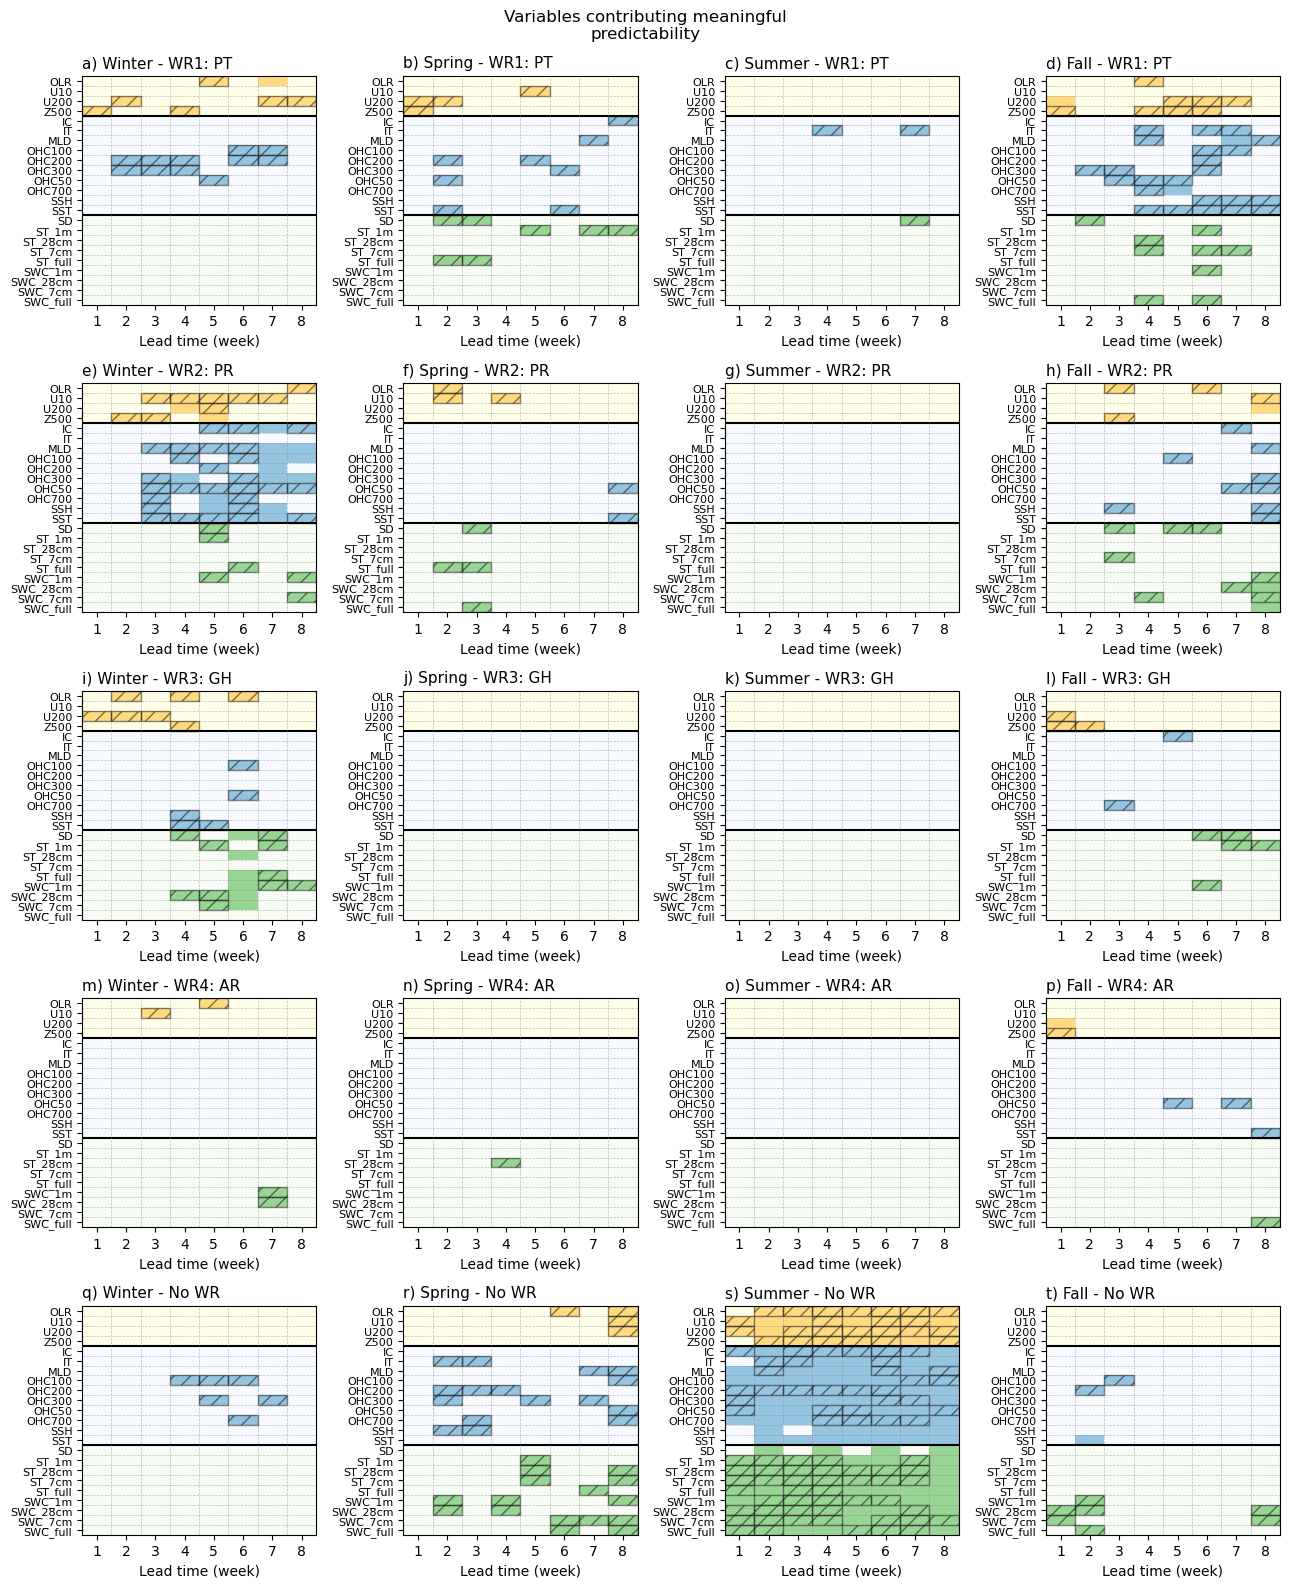

In [67]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(5, 4, figsize=(13, 16))  # 4x4 grid of subplots
axs_list = axs.flatten().tolist()

counter2 = 0
for weather_regime, weather_regime_name in enumerate(names_wr):
    wr = weather_regime
    for iseason, season in enumerate(indices_seasons.keys()):
        # Plot the main data
        cmesh = axs_list[counter2].pcolormesh(weeks, 
                                             np.arange(len(names_vars_figures))[:4], 
                                             dic_good[f'{weather_regime}_{season}'][:4], cmap='afmhot_r', vmin=-0.2, vmax=3.2,alpha=0.7)
        cmesh = axs_list[counter2].pcolormesh(weeks, 
                                             np.arange(len(names_vars_figures))[4:14], 
                                             dic_good[f'{weather_regime}_{season}'][4:14], cmap='Blues', vmin=0, vmax=2.5)
        cmesh = axs_list[counter2].pcolormesh(weeks, 
                                             np.arange(len(names_vars_figures))[14:], 
                                             dic_good[f'{weather_regime}_{season}'][14:], cmap='Greens', vmin=0., vmax=2.5)
        # Overlay hatching where binary_best == 1
        for i in range(dic_best[f'{weather_regime}_{season}'].shape[0]):
            for j in range(dic_best[f'{weather_regime}_{season}'].shape[1]):
                if dic_best[f'{weather_regime}_{season}'][i, j] == 1:
                    rect = plt.Rectangle((weeks[j] - 0.5, i - 0.5), 1, 1, facecolor='none', 
                                          edgecolor='black', hatch='//', alpha=0.5)
                    axs_list[counter2].add_patch(rect)
        
        for xpos in np.arange(0.5,9,1):
            axs_list[counter2-1].axvline(xpos, color='gray', ls='dashed', alpha=0.5, lw=0.5)
        
        for ypos in np.arange(0.5,23,1):
            axs_list[counter2].axhline(ypos, color='gray', ls='dashed', alpha=0.5, lw=0.5)
        
        axs_list[counter2].axhline(3.5, color='k')
        axs_list[counter2].axhline(13.5, color='k')
        
        # Adjust axes
        axs_list[counter2].set_yticks(np.arange(len(names_vars_figures)))
        axs_list[counter2].set_yticklabels(names_vars_figures,fontsize=8)
        axs_list[counter2].set_xticks(weeks)
        axs_list[counter2].set_xlabel('Lead time (week)')
        
        axs_list[counter2].set_title(f"{alphabet[counter2]}) {season} - {names_wr[wr]}", loc="left", fontsize=11)
        
        # Invert the y-axis
        axs_list[counter2].invert_yaxis()
        counter2=counter2+1
# axs_list[-1].remove()
fig.suptitle('Variables contributing meaningful\npredictability',fontsize=12,y=0.99)
plt.tight_layout()
plt.savefig('7_VarsContributionWRs_seasonally.pdf',bbox_inches='tight')

# Predictability starting from different weather regimes

In [97]:
path_f1s_starting_wrs = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_startwrs/'

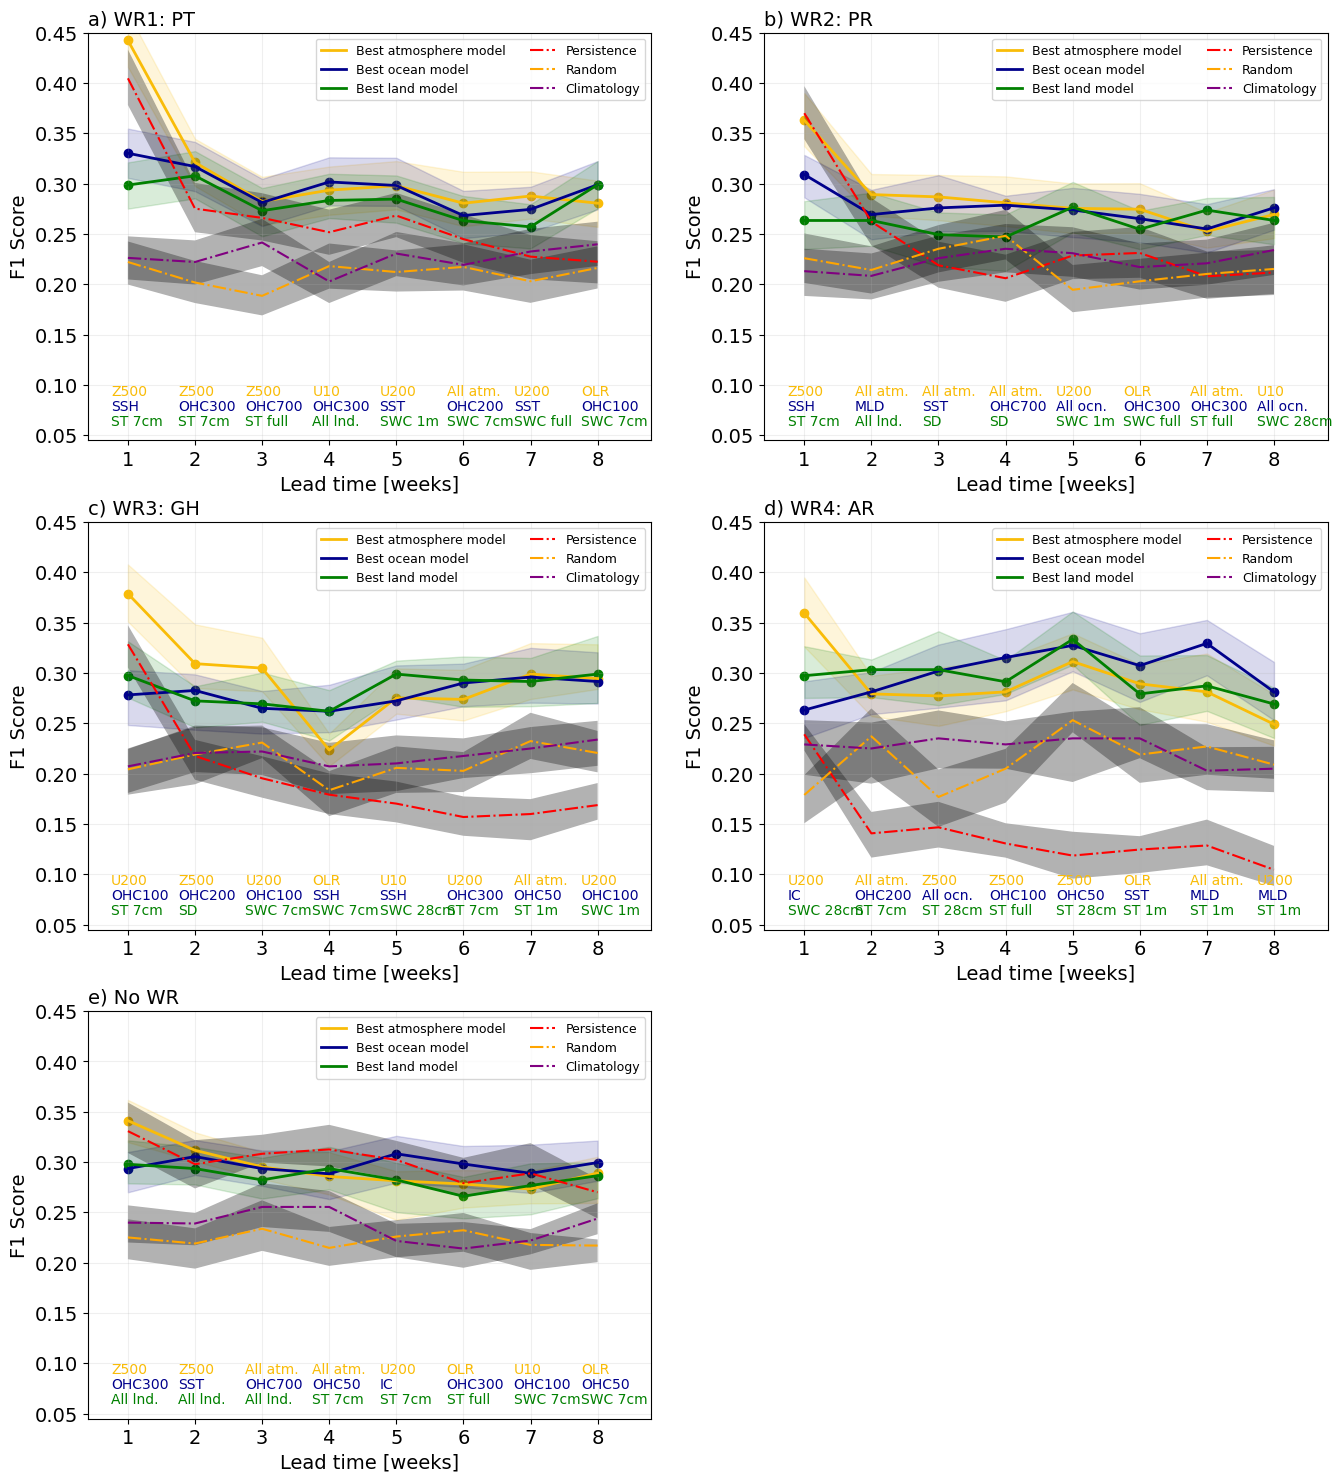

In [98]:
lower_ylim = 0.08
upper_ylim = 0.4

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2,figsize=(16,18))  # 2x2 grid of subplots

# Flatten the axs array and convert to list
axs_list = axs.flatten().tolist()

for weather_regime, weather_regime_name in enumerate(names_wr):
    dic_atm = {}
    dic_atm['all_f1s'] = []
    dic_atm['names'] = []
    
    for ivar in indices_vars_atm:
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_atm['names'].append(list_vars[ivar])
    dic_atm['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}/f1_atm_wr{weather_regime}.npy'))
    dic_atm['names'].append(f'All atm.')
    
    dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
    dic_atm['names'] = np.array(dic_atm['names'])
    dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_ocn = {}
    dic_ocn['all_f1s'] = []
    dic_ocn['names'] = []
    
    for ivar in indices_vars_ocn:
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_ocn['names'].append(list_vars[ivar])
    dic_ocn['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}/f1_ocn_wr{weather_regime}.npy'))
    dic_ocn['names'].append(f'All ocn.')
    
    dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
    dic_ocn['names'] = np.array(dic_ocn['names'])
    dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
    
    dic_lnd = {}
    dic_lnd['all_f1s'] = []
    dic_lnd['names'] = []
    
    for ivar in indices_vars_lnd:
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}f1_{list_vars[ivar]}_wr{weather_regime}.npy'))
        dic_lnd['names'].append(list_vars[ivar])
    dic_lnd['all_f1s'].append(np.load(f'{path_f1s_starting_wrs}/f1_lnd_wr{weather_regime}.npy'))
    dic_lnd['names'].append(f'All lnd.')
    
    dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
    dic_lnd['names'] = np.array(dic_lnd['names'])
    dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
    
    f1_persistence = np.load(f'{path_f1s_starting_wrs}f1_persistence_wr{weather_regime}.npy')
    f1_climatology = np.load(f'{path_f1s_starting_wrs}f1_climatology_wr{weather_regime}.npy')
    f1_random = np.load(f'{path_f1s_starting_wrs}f1_random_wr{weather_regime}.npy')
    f1_all = np.load(f'{path_f1s_starting_wrs}/f1_all_wr{weather_regime}.npy')
    weeks = np.arange(1,9)

    ##### PLOT

    best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
    
    best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                        for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])
    
    axs_list[weather_regime].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
    
    axs_list[weather_regime].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
    
    axs_list[weather_regime].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
    axs_list[weather_regime].scatter(weeks,best_f1_lnd[:,0],color='green')
    
    axs_list[weather_regime].fill_between(weeks, best_f1_atm[:,1], 
                     best_f1_atm[:,2], color='#f9bc08', alpha=alpha)
    axs_list[weather_regime].fill_between(weeks, best_f1_ocn[:,1], 
                     best_f1_ocn[:,2], color='darkblue', alpha=alpha)
    axs_list[weather_regime].fill_between(weeks, best_f1_lnd[:,1], 
                     best_f1_lnd[:,2], color='green', alpha=alpha)
    
    # Plot benchmarks
    axs_list[weather_regime].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                          color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
    
    
    axs_list[weather_regime].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                          color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
    
    axs_list[weather_regime].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
    axs_list[weather_regime].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                          color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
    # ## Plot joint model
    # axs_list[weather_regime].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
    
    constant = -0.16

    # Plot best model
    for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25, 0.25+constant, s=d.replace('_ERA5',''), 
                      color = '#f9bc08',fontsize=10)
    for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25, 0.235+constant, s=d.replace('_SODA','').replace('_OISSTv2','')\
                      .replace('_wT',' \nwT'), 
                      color = 'darkblue',fontsize=10)
    for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        axs_list[weather_regime].text(i - 0.25,  0.22+constant, s=d.replace('SWVL','SWC').replace('STL','ST')\
                      .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
                      color = 'green',fontsize=10)
    
    axs_list[weather_regime].set_xlim(0.4, 8.8)
    axs_list[weather_regime].set_ylim(0.045, 0.45)
    axs_list[weather_regime].tick_params(axis='both', which='major', labelsize=14)
    axs_list[weather_regime].grid(alpha=0.2)
    axs_list[weather_regime].set_ylabel('F1 Score',fontsize=14)
    axs_list[weather_regime].set_xlabel('Lead time [weeks]',fontsize=14)
    abcd = list(string.ascii_lowercase)
    axs_list[weather_regime].set_title(f'{abcd[weather_regime]}) {weather_regime_name}', loc='left',fontsize=14)
    axs_list[weather_regime].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=2)

axs_list[-1].remove()
# plt.savefig('Figures/3_f1WRs.png',bbox_inches='tight')

# Predictability starting in different WRs performance seasonally

In [99]:
path_f1s_starting_wrs_seasonal = '/glade/derecho/scratch/jhayron/Data4Predictability/ResultsXGBoost/F1s_v20241226/f1s_startwrs_seasonal/'

WR1: PT
Winter
['Z500_ERA5' 'OLR_ERA5' 'OLR_ERA5' 'Z500_ERA5' 'OLR_ERA5' 'U10_ERA5'
 'U200_ERA5' 'OLR_ERA5']
['OHC50_SODA' 'OHC200_SODA' 'OHC300_SODA' 'OHC300_SODA' 'SST_OISSTv2'
 'OHC100_SODA' 'OHC100_SODA' 'MLD_SODA']
['STL_full_ERA5' 'STL_7cm_ERA5' 'SD_ERA5' 'STL_28cm_ERA5' 'STL_7cm_ERA5'
 'STL_28cm_ERA5' 'STL_full_ERA5' 'SWVL_7cm_ERA5']
Spring
['Z500_ERA5' 'Z500_ERA5' 'OLR_ERA5' 'U10_ERA5' 'U200_ERA5' 'All atm.'
 'U200_ERA5' 'U10_ERA5']
['MLD_SODA' 'SSH_SODA' 'IT_SODA' 'OHC300_SODA' 'OHC50_SODA' 'IT_SODA'
 'OHC300_SODA' 'OHC100_SODA']
['SWVL_28cm_ERA5' 'SD_ERA5' 'STL_full_ERA5' 'STL_full_ERA5' 'STL_1m_ERA5'
 'SWVL_full_ERA5' 'SD_ERA5' 'STL_28cm_ERA5']
Summer
['U200_ERA5' 'Z500_ERA5' 'Z500_ERA5' 'OLR_ERA5' 'Z500_ERA5' 'U10_ERA5'
 'OLR_ERA5' 'OLR_ERA5']
['SST_OISSTv2' 'OHC300_SODA' 'IC_SODA' 'OHC200_SODA' 'SST_OISSTv2'
 'SSH_SODA' 'IC_SODA' 'OHC100_SODA']
['STL_full_ERA5' 'STL_1m_ERA5' 'STL_1m_ERA5' 'SWVL_28cm_ERA5'
 'SWVL_1m_ERA5' 'SWVL_7cm_ERA5' 'SWVL_7cm_ERA5' 'SWVL_7cm_ERA5']
Fal

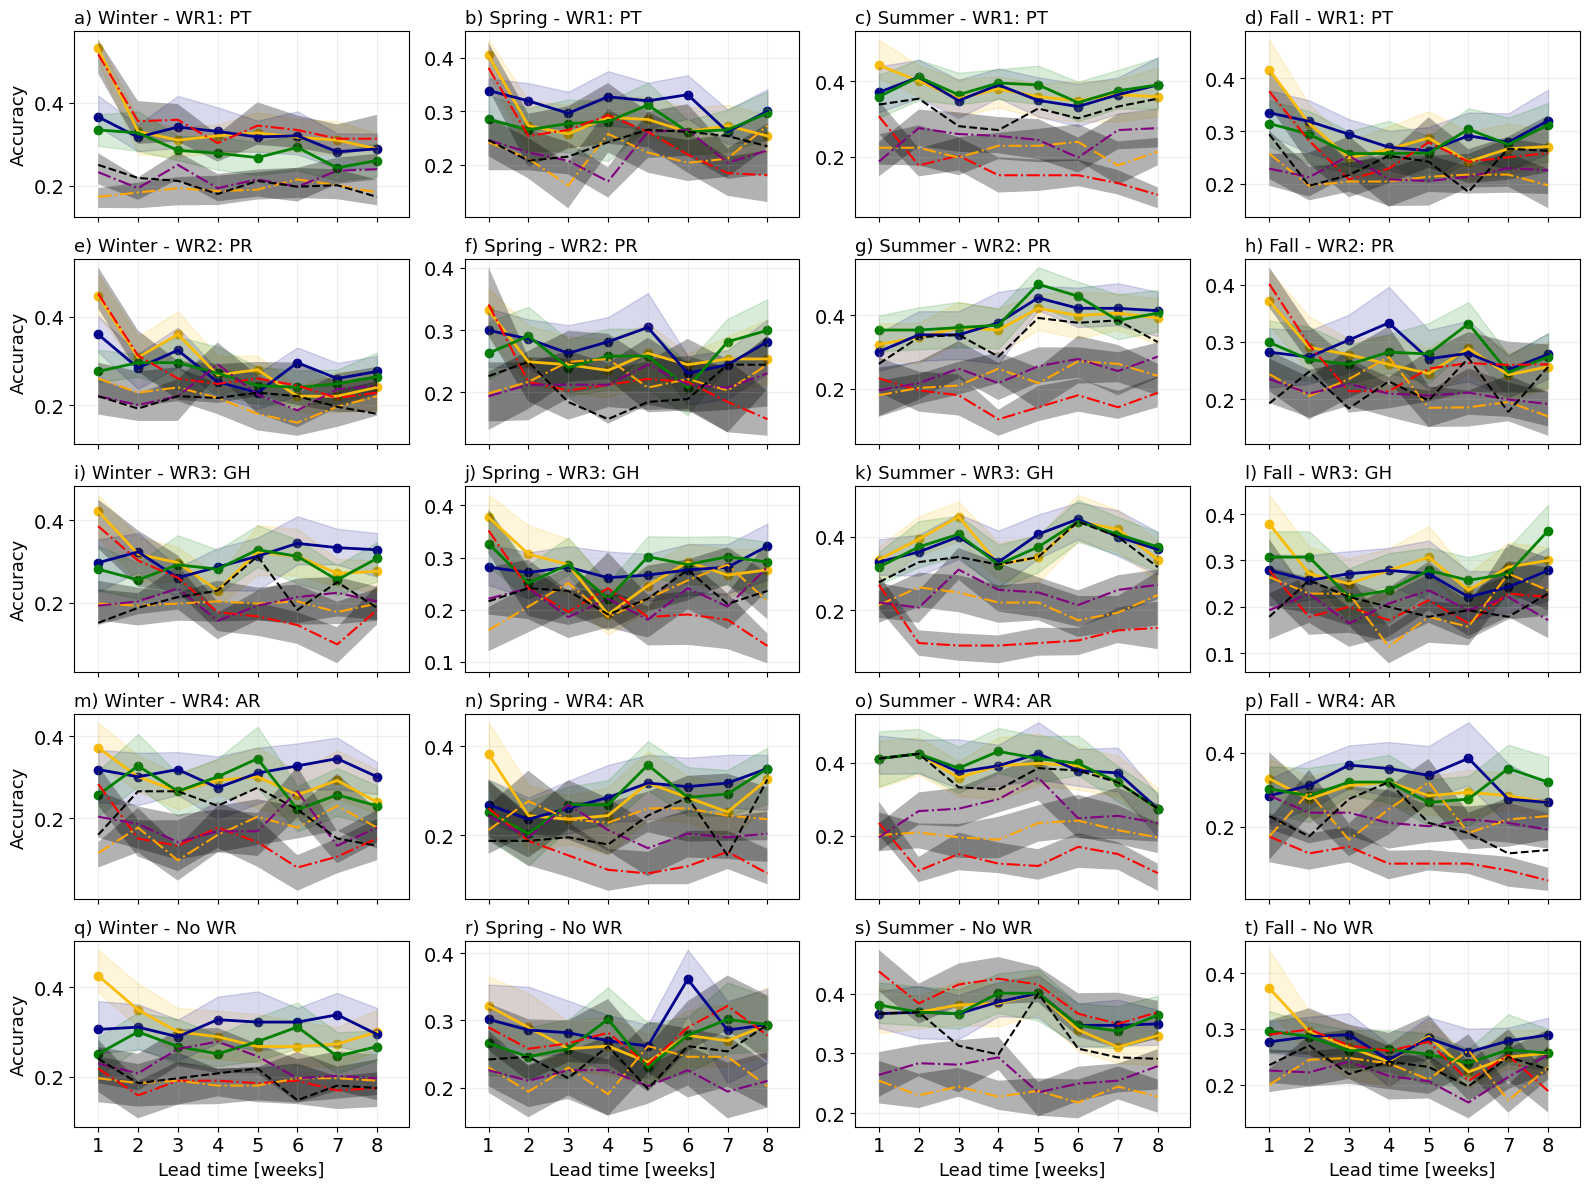

In [100]:
alphabet = list(string.ascii_lowercase)
weeks = np.arange(1, 9)

# Create a figure and a set of subplots
fig, axs = plt.subplots(5, 4, figsize=(16, 12))  # 4x4 grid of subplots
axs_list = axs.flatten().tolist()

counter2 = 0
for weather_regime, weather_regime_name in enumerate(names_wr):
    print(weather_regime_name)
    wr = weather_regime
    for iseason, season in enumerate(indices_seasons.keys()):
        print(season)
        dic_atm = {}
        dic_atm['all_f1s'] = []
        dic_atm['names'] = []
        
        for ivar in indices_vars_atm:
            dic_atm['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_atm['names'].append(list_vars[ivar])
        dic_atm['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}/f1_atm_wr{weather_regime}_{season}.npy'))
        dic_atm['names'].append(f'All atm.')
        
        dic_atm['all_f1s'] = np.array(dic_atm['all_f1s'])
        dic_atm['names'] = np.array(dic_atm['names'])
        dic_atm['best_model'] = dic_atm['names'][dic_atm['all_f1s'][:,:,0].argmax(axis=0)]
        
        dic_ocn = {}
        dic_ocn['all_f1s'] = []
        dic_ocn['names'] = []
        
        for ivar in indices_vars_ocn:
            dic_ocn['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_ocn['names'].append(list_vars[ivar])
        dic_ocn['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}/f1_ocn_wr{weather_regime}_{season}.npy'))
        dic_ocn['names'].append(f'All ocn.')
        
        dic_ocn['all_f1s'] = np.array(dic_ocn['all_f1s'])
        dic_ocn['names'] = np.array(dic_ocn['names'])
        dic_ocn['best_model'] = dic_ocn['names'][dic_ocn['all_f1s'][:,:,0].argmax(axis=0)]
        
        dic_lnd = {}
        dic_lnd['all_f1s'] = []
        dic_lnd['names'] = []
        
        for ivar in indices_vars_lnd:
            dic_lnd['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}f1_{list_vars[ivar]}_wr{weather_regime}_{season}.npy'))
            dic_lnd['names'].append(list_vars[ivar])
        dic_lnd['all_f1s'].append(np.load(f'{path_f1s_starting_wrs_seasonal}/f1_lnd_wr{weather_regime}_{season}.npy'))
        dic_lnd['names'].append(f'All lnd.')
        
        dic_lnd['all_f1s'] = np.array(dic_lnd['all_f1s'])
        dic_lnd['names'] = np.array(dic_lnd['names'])
        dic_lnd['best_model'] = dic_lnd['names'][dic_lnd['all_f1s'][:,:,0].argmax(axis=0)]
        
        f1_persistence = np.load(f'{path_f1s_starting_wrs_seasonal}f1_persistence_wr{weather_regime}_{season}.npy')
        f1_climatology = np.load(f'{path_f1s_starting_wrs_seasonal}f1_climatology_wr{weather_regime}_{season}.npy')
        f1_random = np.load(f'{path_f1s_starting_wrs_seasonal}f1_random_wr{weather_regime}_{season}.npy')
        f1_all = np.load(f'{path_f1s_starting_wrs_seasonal}/f1_all_wr{weather_regime}_{season}.npy')
    
        best_f1_atm = np.array([dic_atm['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_atm['all_f1s'][:,:,0].argmax(axis=0))])
        
        best_f1_ocn = np.array([dic_ocn['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_ocn['all_f1s'][:,:,0].argmax(axis=0))])
        
        best_f1_lnd = np.array([dic_lnd['all_f1s'][iwhere, iweek]\
                            for iweek, iwhere in enumerate(dic_lnd['all_f1s'][:,:,0].argmax(axis=0))])

        print(dic_atm['best_model'])
        print(dic_ocn['best_model'])
        print(dic_lnd['best_model'])
        
        axs_list[counter2].plot(weeks,best_f1_atm[:,0],label=f'Best atmosphere model',color='#f9bc08',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_atm[:,0],color='#f9bc08')#, s=diff*100)
        
        axs_list[counter2].plot(weeks,best_f1_ocn[:,0],label=f'Best ocean model',color='darkblue',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_ocn[:,0],color='darkblue')
        
        axs_list[counter2].plot(weeks,best_f1_lnd[:,0],label=f'Best land model',color='green',lw=2)
        axs_list[counter2].scatter(weeks,best_f1_lnd[:,0],color='green')
        
        axs_list[counter2].fill_between(weeks, best_f1_atm[:,1], 
                         best_f1_atm[:,2], color='#f9bc08', alpha=alpha)
        axs_list[counter2].fill_between(weeks, best_f1_ocn[:,1], 
                         best_f1_ocn[:,2], color='darkblue', alpha=alpha)
        axs_list[counter2].fill_between(weeks, best_f1_lnd[:,1], 
                         best_f1_lnd[:,2], color='green', alpha=alpha)
        
        # Plot benchmarks
        axs_list[counter2].plot(weeks, f1_persistence[:,0], color='red', label='Persistence', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_persistence[:,1],f1_persistence[:,2], 
                              color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
        
        
        axs_list[counter2].plot(weeks, f1_random[:,0], color='orange', label='Random', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_random[:,1],f1_random[:,2], 
                              color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
        
        axs_list[counter2].plot(weeks, f1_climatology[:,0], color='purple', label='Climatology', ls='dashdot')
        axs_list[counter2].fill_between(weeks, f1_climatology[:,1],f1_climatology[:,2], 
                              color='k', ls='dashdot', lw=0.01,alpha=alpha_benchmarks)
        ## Plot joint model
        axs_list[counter2].plot(weeks, f1_all[:,0], color='k', label='All vars.', ls='dashed')
        
        # constant = -0.12
        # if weather_regime==2:
        #     constant = 0.07
        # if weather_regime==3:
        #     constant = 0.07
        # if weather_regime==4:
        #     constant = -0.06
        # # Plot best model
        # for i, j, d in zip(weeks, best_f1_atm[:,0], dic_atm['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25, 0.20+constant, s=d.replace('_ERA5',''), 
        #                   color = '#f9bc08',fontsize=10)
        # for i, j, d in zip(weeks, best_f1_ocn[:,0], dic_ocn['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25, 0.19+constant, s=d.replace('_SODA','').replace('_OISSTv2','')\
        #                   .replace('_wT',' \nwT'), 
        #                   color = 'darkblue',fontsize=10)
        # for i, j, d in zip(weeks, best_f1_lnd[:,0], dic_lnd['best_model'][:]):
        #     axs_list[counter2].text(i - 0.25,  0.18+constant, s=d.replace('SWVL','SWC').replace('STL','ST')\
        #                   .replace('_ERA5','').replace('_',' ').replace(' wT',' \nwT'), 
        #                   color = 'green',fontsize=10)
        
        axs_list[counter2].set_xlim(0.4, 8.8)
        # axs_list[counter2].set_ylim(0.0, 0.45)
        axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        axs_list[counter2].grid(alpha=0.2)
        # axs_list[counter2].set_ylabel('F1 Score',fontsize=14)
        # axs_list[counter2].set_xlabel('Lead time [weeks]',fontsize=14)
        abcd = list(string.ascii_lowercase)
        axs_list[counter2].set_title(f'{abcd[weather_regime]}) {weather_regime_name}', loc='left',fontsize=14)
        # axs_list[counter2].legend(bbox_to_anchor=(1, 1.0), fontsize=9,ncol=3)

        if iseason % 4 == 0:
            axs_list[counter2].set_ylabel("Accuracy", fontsize=13)
            axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        # else:
        #     axs_list[counter2].tick_params(labelleft=False)
        if wr == 4:
            axs_list[counter2].set_xlabel("Lead time [weeks]", fontsize=13)
            axs_list[counter2].set_xticks(np.arange(1, 9))
            axs_list[counter2].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs_list[counter2].set_xticks(np.arange(1, 9))
            axs_list[counter2].tick_params(labelbottom=False)
        
        # Calculate the counter based on row and column position
        # counter = iseason + wr * len(seasons)
        
        axs_list[counter2].set_title(f"{alphabet[counter2]}) {season} - {names_wr[wr]}", loc="left", fontsize=13)
        counter2 += 1
plt.tight_layout()


In [105]:
10**2.5

316.22776601683796